<center><h1>Vertical Optical Depth and Dendrometer-derived Canopy Water Content</h1></center>
<center><h2>Comparative Analysis</h2></center>


This Jupyter Notebook is a step-by-step guide to reproduce the material for the comparative analysis between modelled canopy Gravimetric Moisture Content (GMC) records with two Vertical Optical Depth pructs. This corresponds to the Section 2.4. from the M.Sc. Thesis Research _"Forest Health Monitoring: Dendrometers as Continuous Canopy Water Content Sensors for the Validation of Microwave Remote Sensing Products"_ (Guglielmi, 2025). 

It requires downloading the VODCA v2 datasets from : https://researchdata.tuwien.at/records/t74ty-tcx62 (Zotta et al., 2024)

### Table of Content: 

0. Required libraries
1. Loading and inspect VODCA files
2. Identify the pixels of interest
3. Create time series of VOD for the two pixels
4. Detrend the DendroPortaal dendrometer data
5. Apply the model to the TWD
6. Visualize the VOD and the output canopy GMC
7. Plot weekly average + spearman correlation

# 0. Requires libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from netCDF4 import Dataset
from glob import glob
import calendar
import datetime
from scipy.stats import pearsonr, spearmanr

# 1. Loading and inspect VODCA files

This section allows to inspect one VOD file to identify the variables and shape of the data.

In [2]:
# create the path to the file
chosen_year = '2019' #chose a year
chosen_date = '05-01' #chose one date to inspect dataset
vodca_product = 'VODCA_L'# alternative: 'VODCA_CXKu'

vodca_file_path = f"/Users/bereniceguglielmi/Desktop/Current_2025/M.Sc. Thesis/FInal Thesis/{vodca_product}_2017_2021/{chosen_year}/daily_images_{chosen_year}-{chosen_date}.nc"
nc_file = Dataset(vodca_file_path, mode='r')
print(f'File data structure:{nc_file}')
print(f'variables:{nc_file.variables[vodca_product]}')

File data structure:<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    calendar: standard
    title: Global long-term Vegetation optical depth climate archive v2
    productname:: VODCA L
    band: VODCA_L
    product_version: 01.0
    insitute: Technical University of Vienna (AUT); Planet Labs, Haarlem (NL)
    contact: vodca@geo.tuwien.ac.at
    sensors: SMOS; SMAP
    frequencies: L band
    conventions: CF-1.6
    standard_name_vocabulary: NetCDF Climate and Forecast (CF) Metadata Convention
    timecoveragestartdate: 2010-01-01T00:00:00
    timecoverageenddate: 2021-12-31T23:59:59
    timecoverageresolution: 10D
    creatorurl: https://www.tuwien.at/mg/geo/climers
    creatorname: Climate and Environmental Remote Sensing Research Unit (CLIMERS);Department of Geodesy and Geoinformation, Technical University of Vienna
    namingauthority: TU Wien
    license: Creative Commons Attribution 4.0 International
    geospatiallatmin: -90.0
    geospatiallatmax

In [3]:
# Dimensions: latitude, longitude, and time
vod_data = nc_file.variables[vodca_product][:]
lat = nc_file.variables['lat'][:]
lon = nc_file.variables['lon'][:]
time = nc_file.variables['time'][:]
print(f"{vodca_product} shape:", vod_data.shape)
print("Latitude shape:", lat.shape)
print("Longitude shape:", lon.shape)
print("Time shape:", time.shape)


VODCA_L shape: (1, 720, 1440)
Latitude shape: (720,)
Longitude shape: (1440,)
Time shape: (1,)


In [4]:
# extract values and relplace missing values

vod_values = vod_data[0, :, :]  #(only 1 time step)
fill_value = nc_file.variables[f"{vodca_product}"]._FillValue
print("Fill Value:", fill_value)
vod_values = np.where(vod_values == fill_value, np.nan, vod_values)


Fill Value: -999999.0


In [5]:
# compute basic statistics
vod_values_cleaned = np.where(vod_values == -999999.0, np.nan, vod_values)
print(f" {vodca_product} statistics:")
print("Min (non-NaN):", np.nanmin(vod_values_cleaned))
print("Max (non-NaN):", np.nanmax(vod_values_cleaned))
print("Mean (non-NaN):", np.nanmean(vod_values_cleaned))

 VODCA_L statistics:
Min (non-NaN): 1.611924585964361e-05
Max (non-NaN): 1.052
Mean (non-NaN): 0.21026045822886172


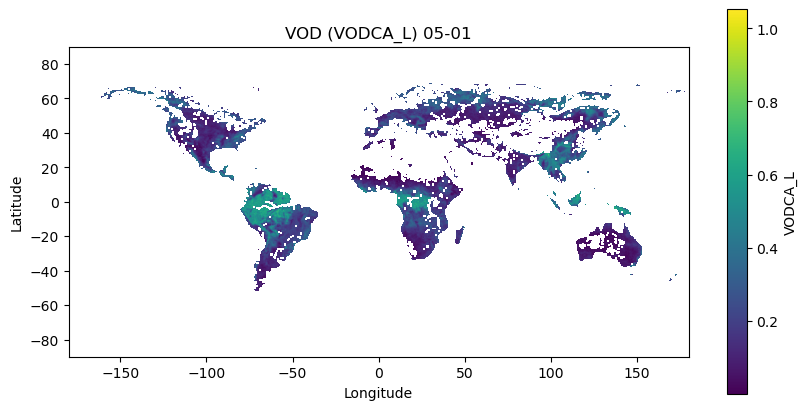

In [6]:
# visualize the data from the selected file

plt.figure(figsize=(10, 5))
plt.imshow(vod_values_cleaned, origin='upper', cmap='viridis', extent=[-180, 180, -90, 90])
plt.colorbar(label=f"{vodca_product}")
plt.title(f"VOD ({vodca_product}) {chosen_date}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2. Identify the pixels of interest

In [9]:
# enter the site's coordinates
locations = {
    "Pijpebrandje": (52.255938444585624, 5.701410491514622),
    "Leesten": (52.15848938309025, 5.907015572753593),
}

In [10]:
# identify the pixels of interests (assuming 2 pixels)

lat = nc_file.variables['lat'][:]
lon = nc_file.variables['lon'][:]

def find_nearest_pix(lat_array, lon_array, target_lat, target_lon):
    lat_idx = np.argmin(np.abs(lat_array - target_lat))
    lon_idx = np.argmin(np.abs(lon_array - target_lon))
    return lat_idx, lon_idx

pixel_indices = {}
for name, (lat_val, lon_val) in locations.items():
    lat_idx, lon_idx = find_nearest_pix(lat, lon, lat_val, lon_val)
    pixel_indices[name] = (lat_idx, lon_idx)

unique_pixels = list(set(pixel_indices.values()))
pixel_names = {unique_pixels[i]: f"Pixel{i+1}" for i in range(len(unique_pixels))}

print("Identified pixels:")
for loc, (lat_idx, lon_idx) in pixel_indices.items():
    print(f"{loc}: ({lat_idx}, {lon_idx}) -> {pixel_names[(lat_idx, lon_idx)]}")



Identified pixels:
Pijpebrandje: (150, 742) -> Pixel1
Leesten: (151, 743) -> Pixel2


# 3. Create time series of VOD for the two pixels

In [ ]:
# edit with the start of the patht to the vodca file
path_root = '/Users/bereniceguglielmi/Desktop/Current_2025/M.Sc. Thesis/FInal Thesis/'
years = ['2017', '2018', '2019', '2020', '2021']

In [12]:
def process_vodca_data(vodca_product, years, pixel_names, path_root):
    time_steps = []
    time_series = {name: [] for name in pixel_names.values()}

    for year in years:
        for month in range(1, 13):
            if vodca_product == "VODCA_L":
                days_of_month = [1, 11, 21]
            else:
                last_day = calendar.monthrange(int(year), month)[1]
                days_of_month = range(1, last_day + 1)

            for day in days_of_month:
                try:
                    chosen_date = f"{year}-{month:02d}-{day:02d}"
                    vodca_file_path = f"{path_root}{vodca_product}_2017_2021/{year}/daily_images_{chosen_date}.nc" # edit the path again if needed
                    
                    with Dataset(vodca_file_path, mode='r') as nc:
                        vod_data = nc.variables[vodca_product][:]
                        time_steps.append(chosen_date)

                        for (lat_idx, lon_idx), pixel_name in pixel_names.items():
                            value = vod_data[0, lat_idx, lon_idx]
                            fill_value = nc.variables[vodca_product]._FillValue
                            value = np.nan if value == fill_value else value
                            time_series[pixel_name].append(value)

                except FileNotFoundError:
                    print(f"file not found: {vodca_file_path}")
                    continue

    for pixel, values in time_series.items():
        time_series[pixel] = np.array(values)

    if vodca_product == "VODCA_L":
        timeseries_pixel_1 = time_series.get("Pixel1", np.array([]))
        timeseries_pixel_2 = time_series.get("Pixel2", np.array([]))
        avg_vod = np.nanmean(np.array([timeseries_pixel_1, timeseries_pixel_2]), axis=0)
    else:
        timeseries_pixel_1 = time_series.get("Pixel1", np.array([]))
        timeseries_pixel_2 = time_series.get("Pixel2", np.array([]))
        avg_vod = np.nanmean(np.array([timeseries_pixel_1, timeseries_pixel_2]), axis=0)

    return time_steps, time_series, avg_vod


In [ ]:
time_steps_CXKu, time_series_CXKu, avg_vod_CXKu = process_vodca_data("VODCA_CXKu", years, pixel_names, path_root)
time_steps_L, time_series_L, avg_vod_L = process_vodca_data("VODCA_L", years, pixel_names, path_root)

Plot the two VOD products' values

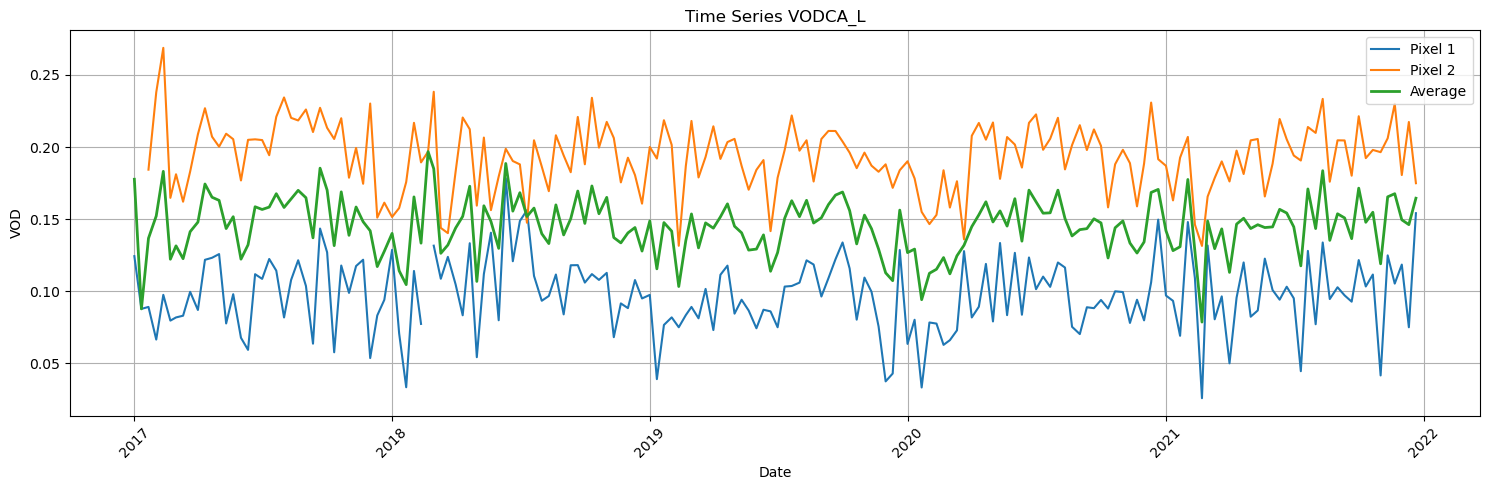

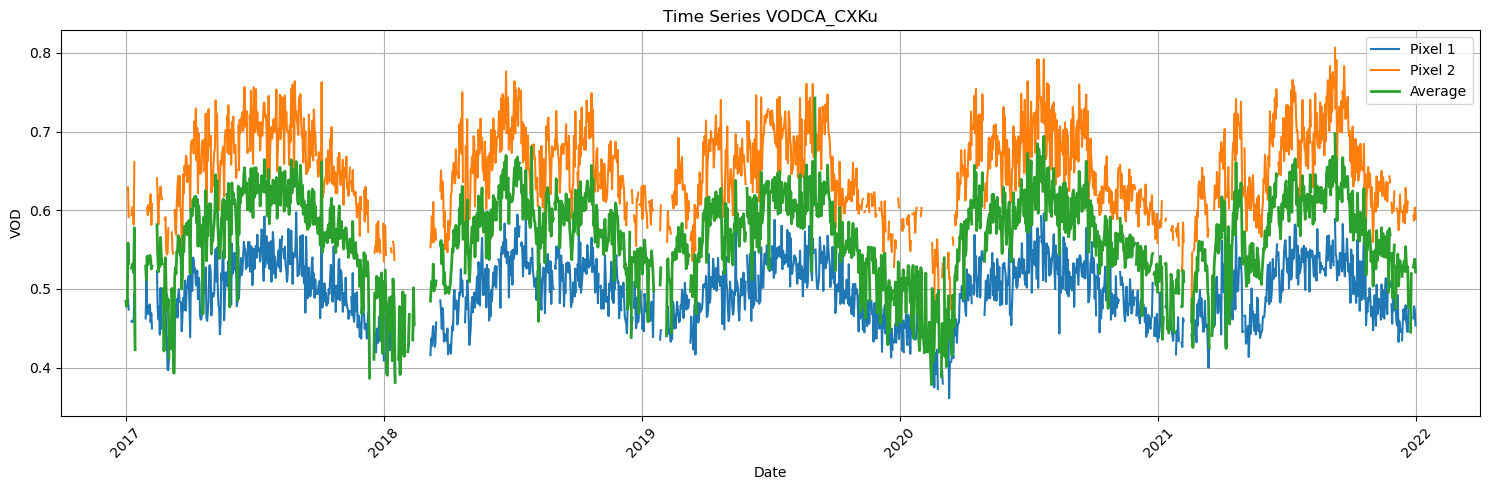

In [16]:
timeseries_pixel_1_L = time_series_L.get("Pixel1", np.array([]))
timeseries_pixel_2_L = time_series_L.get("Pixel2", np.array([]))

timeseries_pixel_1_CXKu = time_series_CXKu.get("Pixel1", np.array([]))
timeseries_pixel_2_CXKu = time_series_CXKu.get("Pixel2", np.array([]))

time_steps_L_dt = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in time_steps_L]
time_steps_CXKu_dt = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in time_steps_CXKu]

#Pixel 1 VODCA L
plt.figure(figsize=(15, 5))
plt.plot(time_steps_L_dt, timeseries_pixel_1_L, label="Pixel 1", linestyle='-', color='tab:blue')
plt.plot(time_steps_L_dt, timeseries_pixel_2_L, label="Pixel 2", linestyle='-', color='tab:orange')
plt.plot(time_steps_L_dt, avg_vod_L, label="Average", linestyle='-', linewidth=2, color='tab:green')
plt.xlabel("Date")
plt.ylabel("VOD")
plt.title("Time Series VODCA_L")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Piel 2 Vodca CXKu
plt.figure(figsize=(15, 5))
plt.plot(time_steps_CXKu_dt, timeseries_pixel_1_CXKu, label="Pixel 1", linestyle='-', color='tab:blue')
plt.plot(time_steps_CXKu_dt, timeseries_pixel_2_CXKu, label="Pixel 2", linestyle='-', color='tab:orange')
plt.plot(time_steps_CXKu_dt, avg_vod_CXKu, label="Average", linestyle='-', linewidth=2, color='tab:green')
plt.xlabel("Date")
plt.ylabel("VOD")
plt.title("Time Series VODCA_CXKu")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Detrend the DendroPortaal dendrometer data

### 4.1. Pre-processing

The data for the Pijebrandje and Leesten sites were obtained upon demand from the DendroPortaal. The files presented the dendrometer variations with a column for each year, and for conveninence the files were reorganised chronologically into a column holding the timestamp and a column holding the stem radius usig the following code, run for each file to be processed.

In [ ]:
file = 'L1'# edit to the path to L1-L5 (Leesten) and J0-J5 (Pijpebrandje)
file_path = f"path/to/{file}.csv" 

df = pd.read_csv(file_path, parse_dates=["groeiseizoen"])
df_long = df.melt(id_vars=["groeiseizoen"], var_name="year", value_name="stem")
df_long["timestamp"] = df_long.apply(lambda row: row["groeiseizoen"].replace(year=int(row["year"])), axis=1)
df_long = df_long[["timestamp", "stem"]]


output_path = f"paht/to/{file}.xlsx"
df_long.to_excel(output_path, index=False)
print(df_long.head())

print(f"Processed file saved at: {output_path}")

### 4.2. Detrend Leesten

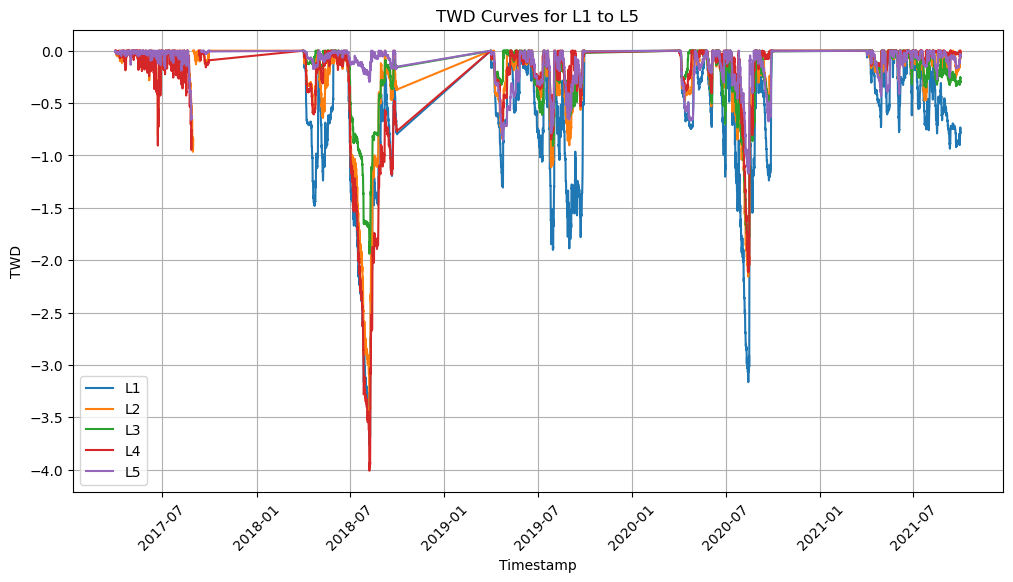

In [17]:
leesten = {}

files = ['L1', 'L2', 'L3', 'L4', 'L5']

for file in files:
    file_path = f"/Users/bereniceguglielmi/Desktop/DendroPortaal Data/{file}.xlsx" #edit the path to folder holding the files
    df = pd.read_excel(file_path, parse_dates=["timestamp"])
    df = df[(df["timestamp"] >= "2017-01-01 00:00") & (df["timestamp"] <= "2021-12-31 23:00")]
    df = df.reset_index(drop=True)
    df["GRO"] = df["stem"].copy()

    for i in range(1, len(df)): #reset for every growing season
        if df.loc[i, "timestamp"].month == 4 and df.loc[i, "timestamp"].day == 1 and df.loc[i, "timestamp"].hour == 0:
            df.loc[i, "GRO"] = df.loc[i, "stem"]
        else:
            df.loc[i, "GRO"] = max(df.loc[i, "stem"], df.loc[i - 1, "GRO"]) 

    df["TWD"] = df["stem"] - df["GRO"]

    leesten[file] = df

#plot to verify : 

plt.figure(figsize=(12, 6))
for key, df in leesten.items():
    plt.plot(df["timestamp"], df["TWD"], label=key)  
plt.xlabel("Timestamp")
plt.ylabel("TWD")
plt.title("TWD Curves for L1 to L5")
plt.legend()  
plt.grid(True) 
plt.xticks(rotation=45)  
plt.show()


### 4.3. Detrend Pijebrandje

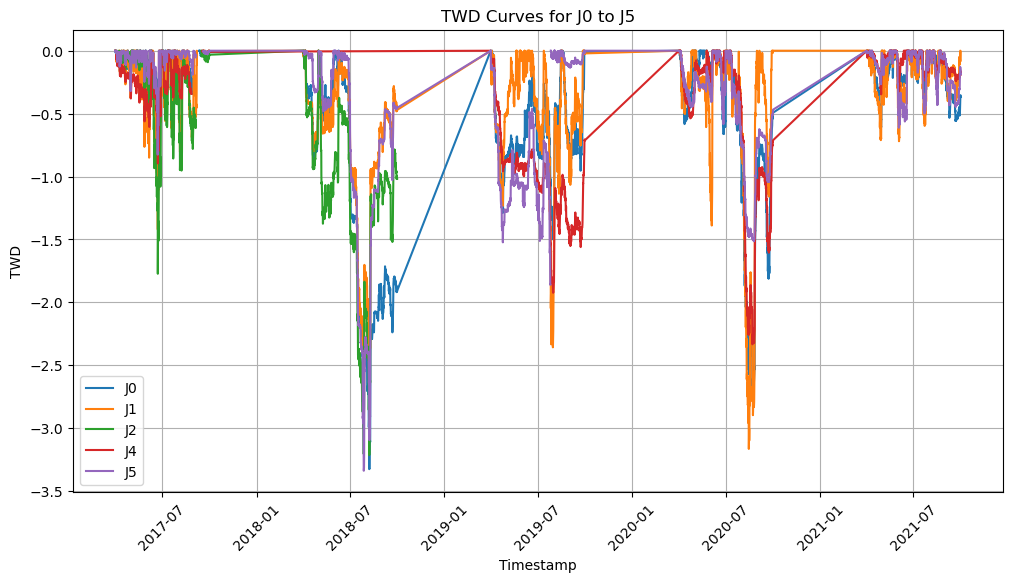

In [28]:
pijpebrandje = {}

files = ['J0', 'J1', 'J2', 'J4', 'J5']

for file in files:
    file_path = f"/Users/bereniceguglielmi/Desktop/DendroPortaal Data/{file}.xlsx" #edit the path to folder holding the files
    df = pd.read_excel(file_path, parse_dates=["timestamp"])
    df = df[(df["timestamp"] >= "2017-01-01 00:00") & (df["timestamp"] <= "2021-12-31 23:00")]
    df = df.reset_index(drop=True)
    df["GRO"] = df["stem"].copy()

    for i in range(1, len(df)): #reset for every growing season
        if df.loc[i, "timestamp"].month == 4 and df.loc[i, "timestamp"].day == 1 and df.loc[i, "timestamp"].hour == 0:
            df.loc[i, "GRO"] = df.loc[i, "stem"]
        else:
            df.loc[i, "GRO"] = max(df.loc[i, "stem"], df.loc[i - 1, "GRO"]) 

    df["TWD"] = df["stem"] - df["GRO"]

    pijpebrandje[file] = df

#plot to verify : 

plt.figure(figsize=(12, 6))
for key, df in pijpebrandje.items():
    plt.plot(df["timestamp"], df["TWD"], label=key)  
plt.xlabel("Timestamp")
plt.ylabel("TWD")
plt.title("TWD Curves for J0 to J5")
plt.legend()  
plt.grid(True) 
plt.xticks(rotation=45)  
plt.show()


### 4.4. Average TWD per site

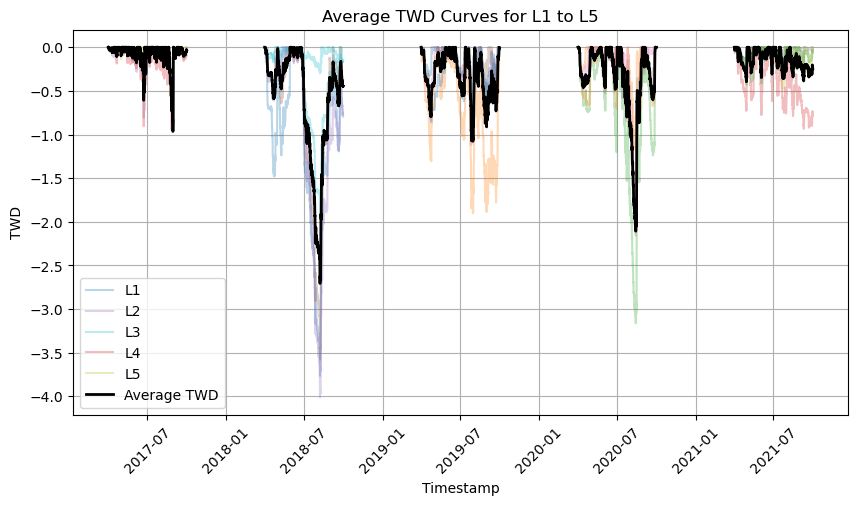

In [26]:
# LEESTEN AVERAGE
plt.figure(figsize=(10, 5))

def plot_segmented_data(df, column, label, color=None, alpha=1, linewidth=1.5):
    df_sorted = df.sort_values(by="timestamp").copy()  
    df_sorted["gap"] = (df_sorted["timestamp"].diff().dt.days > 1).cumsum()  # makes gap to not connect the point over winter

    for _, segment in df_sorted.groupby("gap"):
        plt.plot(segment["timestamp"], segment[column], linestyle='-', label=label if _ == 0 else "",
                 color=color, alpha=alpha, linewidth=linewidth)


for key, df in leesten.items():
    plot_segmented_data(df, "TWD", label=key, alpha=0.3)

merged_df_l = pd.concat([df.set_index("timestamp")["TWD"] for df in leesten.values()], axis=1)
merged_df_l["Average_TWD"] = merged_df_l.mean(axis=1, skipna=True)
avg_df_l = merged_df_l[["Average_TWD"]].dropna().reset_index()


plot_segmented_data(avg_df_l, "Average_TWD", label="Average TWD", color="black", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("TWD")
plt.title("Average TWD Curves for L1 to L5")
plt.legend()  
plt.grid(True)  
plt.xticks(rotation=45)
plt.show()


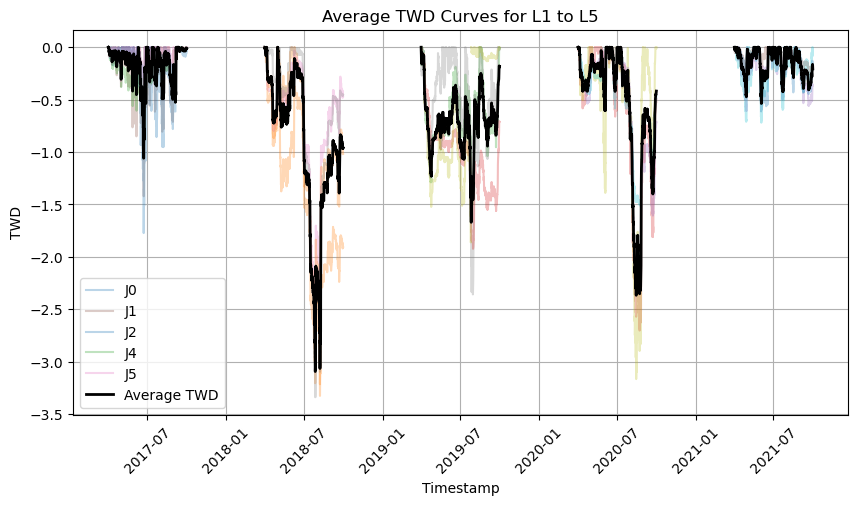

In [29]:
# PIJPEBRANDJE AVERAGE
plt.figure(figsize=(10, 5))


for key, df in pijpebrandje.items():
    plot_segmented_data(df, "TWD", label=key, alpha=0.3)

merged_df_p = pd.concat([df.set_index("timestamp")["TWD"] for df in pijpebrandje.values()], axis=1)
merged_df_p["Average_TWD"] = merged_df_p.mean(axis=1, skipna=True)
avg_df_p = merged_df_p[["Average_TWD"]].dropna().reset_index()


plot_segmented_data(avg_df_p, "Average_TWD", label="Average TWD", color="black", linewidth=2)

plt.xlabel("Timestamp")
plt.ylabel("TWD")
plt.title("Average TWD Curves for L1 to L5")
plt.legend()  
plt.grid(True)  
plt.xticks(rotation=45)
plt.show()


# 5. Apply the model to the TWD 

The model to constaint the TWD curves is applied following the steps described in the M.Sc. Thesis and using the parameters that performed the best for the band dendrometer. The constraining values are the one for Douglas Fir determined in the M.Sc. Thesis research. The values stored in _boundaries_data.csv_ are stored in on the repository.

In [24]:
boundaries_path = "path/to/boundaries_data.csv" #edit
boundaries_df = pd.read_csv(boundaries_path, parse_dates=[0], index_col=0)
print(boundaries_df)

                  Max     AvgMax    Average     AvgMin        Min
2024-01-01  57.983193  52.810467  51.941570  51.132345  47.368421
2024-01-02  57.977284  52.760503  51.891252  51.074834  47.330692
2024-01-03  57.971374  52.710538  51.840935  51.017323  47.292964
2024-01-04  57.965465  52.660573  51.790617  50.959811  47.255235
2024-01-05  57.959555  52.610608  51.740299  50.902300  47.217506
...               ...        ...        ...        ...        ...
2024-12-27  57.627119  51.496511  50.764442  50.002666  46.808511
2024-12-28  57.627119  51.496511  50.764442  50.002666  46.808511
2024-12-29  57.627119  51.496511  50.764442  50.002666  46.808511
2024-12-30  57.627119  51.496511  50.764442  50.002666  46.808511
2024-12-31  57.627119  51.496511  50.764442  50.002666  46.808511

[366 rows x 5 columns]


In [25]:
# reproduce the boundary df for every year between 2017 and 2021

boundaries_df.index = pd.to_datetime(boundaries_df.index)
expanded_dfs = []
for year in range(2017, 2022):  
    temp_df = boundaries_df.copy()
    
    new_index = []
    for date in temp_df.index: 
        try:
            new_index.append(date.replace(year=year)) 
        except ValueError: 
            new_index.append(date.replace(year=year, day=28)) # handle leap year

    temp_df.index = new_index 
    expanded_dfs.append(temp_df)

boundaries_df_expanded = pd.concat(expanded_dfs)
boundaries_df_expanded = boundaries_df_expanded.sort_index()  
boundaries_df = boundaries_df_expanded #combine all back into the df

Constrain the TWD

In [33]:
#preparation + functions
merged_L = pd.concat([df.set_index("timestamp")["TWD"] for df in leesten.values()], axis=1)
leesten_average_TWD = merged_L.mean(axis=1, skipna=True) 
leesten_average_TWD = leesten_average_TWD.reset_index()
leesten_average_TWD.columns = ["timestamp", "Average_TWD"]


merged_P = pd.concat([df.set_index("timestamp")["TWD"] for df in pijpebrandje.values()], axis=1)
pijpebrandje_average_TWD = merged_P.mean(axis=1, skipna=True) 
pijpebrandje_average_TWD = pijpebrandje_average_TWD.reset_index()
pijpebrandje_average_TWD.columns = ["timestamp", "Average_TWD"]


def constrain_twd_month(twd_curve, boundaries_df, upper, lower):
    twd_curve.loc[:, 'timestamp'] = pd.to_datetime(twd_curve['timestamp'])
    boundaries_df.index = pd.to_datetime(boundaries_df.index)
    boundaries_df['month'] = boundaries_df.index.month
    monthly_lower_averages = boundaries_df.groupby('month')[lower].mean().to_dict()

    constrained_values = []

    for timestamp, twd_value in zip(twd_curve['timestamp'], twd_curve.iloc[:, 1]):
        day = timestamp.floor('D')
        if day not in boundaries_df.index:
            constrained_values.append(np.nan)
            continue

        upper_bound = boundaries_df.loc[day, upper]
        month = day.month
        lower_bound = boundaries_df.loc[day, lower]
        min_twd = twd_curve[twd_curve['timestamp'].dt.month == month].iloc[:, 1].min()

        if pd.isna(min_twd):
            constrained_values.append(np.nan)
            continue
        if twd_value >= 0: 
            constrained_values.append(upper_bound)
        else:
            constrained_value = lower_bound + (twd_value - min_twd) * (upper_bound - lower_bound) / (0 - min_twd)
            constrained_values.append(constrained_value)
    twd_curve[f"Constrained_{upper}_{lower}"] = constrained_values

    return twd_curve


def plot_segmented_data(ax, df, column, label, color=None, alpha=1, linewidth=1.5):
    df_sorted = df.sort_values(by="timestamp").copy()
    df_sorted["gap"] = (df_sorted["timestamp"].diff().dt.days > 1).cumsum() 

    for _, segment in df_sorted.groupby("gap"):
        ax.plot(segment["timestamp"], segment[column], linestyle='-', 
                label=label if _ == 0 else "", color=color, alpha=alpha, linewidth=linewidth)



constrained for year: 2017
constrained for year: 2018
constrained for year: 2019
constrained for year: 2020
constrained for year: 2021


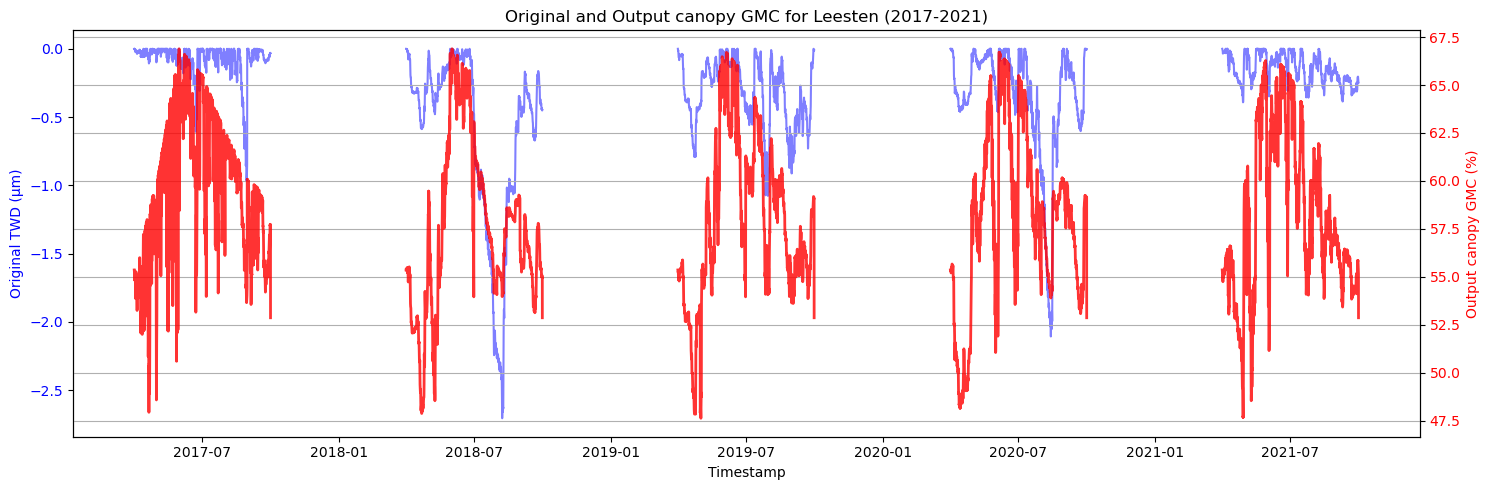

In [34]:
# Constrain LEESTEN

constrained_dataframes = []

for year in range(2017, 2022): 
    yearly_data = leesten_average_TWD[leesten_average_TWD["timestamp"].dt.year == year].copy()
    
    if not yearly_data.empty:
        yearly_data = constrain_twd_month(yearly_data, boundaries_df, upper="Max", lower="Average")
        print("constrained for year:",year)
        constrained_dataframes.append(yearly_data)

constrained_leesten = pd.concat(constrained_dataframes).reset_index(drop=True)


# PLOT Original vs Constrained
fig, ax1 = plt.subplots(figsize=(15, 5))
plot_segmented_data(ax1, leesten_average_TWD.dropna(), "Average_TWD", 
                    label="Original TWD (μm)", color="blue", alpha=0.5, linewidth=1.5)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Original TWD (μm)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax2 = ax1.twinx()
plot_segmented_data(ax2, constrained_leesten.dropna(), "Constrained_Max_Average", 
                    label="Output canopy GMC (%)", color="red", alpha=0.8, linewidth=2)
ax2.set_ylabel("Output canopy GMC (%)", color="red")
ax2.tick_params(axis='y', labelcolor="red")
plt.title("Original and Output canopy GMC for Leesten (2017-2021)")
fig.tight_layout()
plt.grid(True)
plt.show()


constrained for year: 2017
constrained for year: 2018
constrained for year: 2019
constrained for year: 2020
constrained for year: 2021


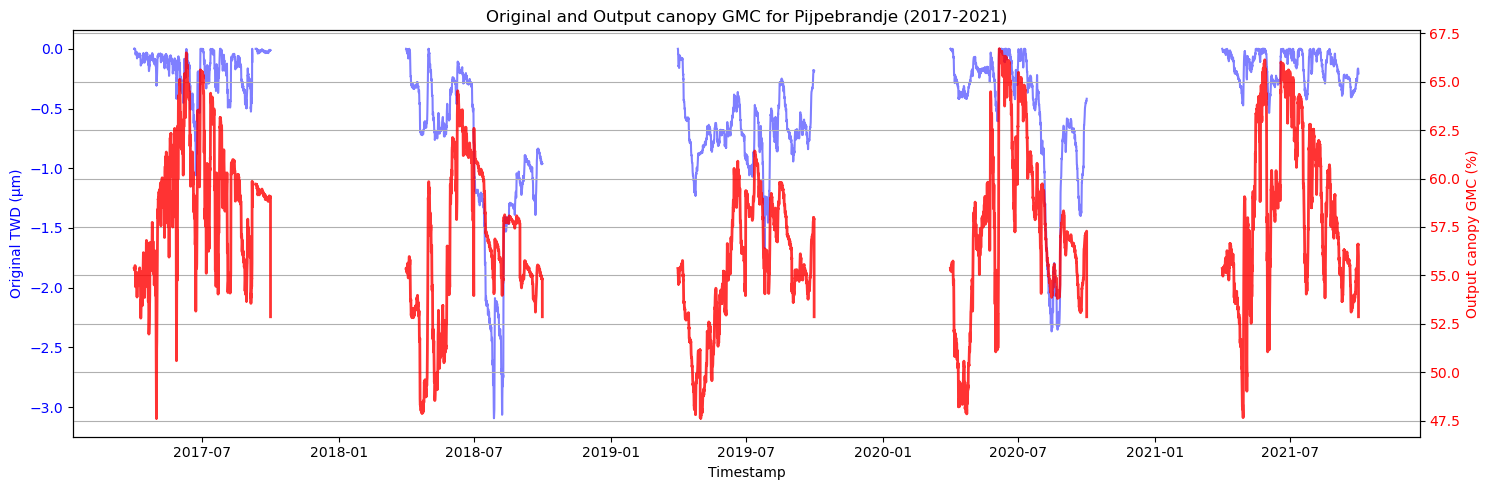

In [35]:
# Constrain PIJPEBRANDJE

constrained_dataframes = []

for year in range(2017, 2022): 
    yearly_data = pijpebrandje_average_TWD[pijpebrandje_average_TWD["timestamp"].dt.year == year].copy()
    
    if not yearly_data.empty:
        yearly_data = constrain_twd_month(yearly_data, boundaries_df, upper="Max", lower="Average")
        print("constrained for year:",year)
        constrained_dataframes.append(yearly_data)

constrained_pijpebrandje = pd.concat(constrained_dataframes).reset_index(drop=True)


# PLOT Original vs Constrained
fig, ax1 = plt.subplots(figsize=(15, 5))
plot_segmented_data(ax1, pijpebrandje_average_TWD.dropna(), "Average_TWD", 
                    label="Original TWD (μm)", color="blue", alpha=0.5, linewidth=1.5)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Original TWD (μm)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax2 = ax1.twinx()
plot_segmented_data(ax2, constrained_pijpebrandje.dropna(), "Constrained_Max_Average", 
                    label="Output canopy GMC (%)", color="red", alpha=0.8, linewidth=2)
ax2.set_ylabel("Output canopy GMC (%)", color="red")
ax2.tick_params(axis='y', labelcolor="red")
plt.title("Original and Output canopy GMC for Pijpebrandje (2017-2021)")
fig.tight_layout()
plt.grid(True)
plt.show()


Compute linear correlation between the two outputs:

In [40]:
constrained_leesten["timestamp"] = pd.to_datetime(constrained_leesten["timestamp"])
constrained_pijpebrandje["timestamp"] = pd.to_datetime(constrained_pijpebrandje["timestamp"])
constrained_leesten["Year"] = constrained_leesten["timestamp"].dt.year
constrained_leesten["Month"] = constrained_leesten["timestamp"].dt.month
constrained_pijpebrandje["Year"] = constrained_pijpebrandje["timestamp"].dt.year
constrained_pijpebrandje["Month"] = constrained_pijpebrandje["timestamp"].dt.month
valid_months = [5, 6, 7, 8, 9] #no winter
constrained_leesten = constrained_leesten[constrained_leesten["Month"].isin(valid_months)]
constrained_pijpebrandje = constrained_pijpebrandje[constrained_pijpebrandje["Month"].isin(valid_months)]
years = sorted(set(constrained_leesten["Year"]).intersection(set(constrained_pijpebrandje["Year"])))

correlation_results = []

for year in years:

    leesten_year = constrained_leesten[constrained_leesten["Year"] == year].set_index("timestamp")
    pijpe_year = constrained_pijpebrandje[constrained_pijpebrandje["Year"] == year].set_index("timestamp")

    common_timestamps = leesten_year.index.intersection(pijpe_year.index)

    if len(common_timestamps) < 3: #minimum 3 values
        correlation_results.append([year, np.nan, np.nan])
        continue

    leesten_values = leesten_year.loc[common_timestamps, "Constrained_Max_Average"]
    pijpe_values = pijpe_year.loc[common_timestamps, "Constrained_Max_Average"]
    valid_data = pd.DataFrame({"leesten": leesten_values, "pijpe": pijpe_values}).dropna()
    valid_data = valid_data[(valid_data != np.inf).all(axis=1)]

    if len(valid_data) < 3:
        correlation_results.append([year, np.nan, np.nan])
        continue

    pearson_corr, pearson_p = pearsonr(valid_data["leesten"], valid_data["pijpe"])
    correlation_results.append([year, pearson_corr, pearson_p])

leesten_all = constrained_leesten.set_index("timestamp")
pijpe_all = constrained_pijpebrandje.set_index("timestamp")
common_timestamps_all = leesten_all.index.intersection(pijpe_all.index)

if len(common_timestamps_all) >= 3:

    leesten_values_all = leesten_all.loc[common_timestamps_all, "Constrained_Max_Average"]
    pijpe_values_all = pijpe_all.loc[common_timestamps_all, "Constrained_Max_Average"]
    valid_data_all = pd.DataFrame({"leesten": leesten_values_all, "pijpe": pijpe_values_all}).dropna()
    valid_data_all = valid_data_all[(valid_data_all != np.inf).all(axis=1)]

    if len(valid_data_all) >= 3:
        pearson_corr_all, pearson_p_all = pearsonr(valid_data_all["leesten"], valid_data_all["pijpe"])
    else:
        pearson_corr_all, pearson_p_all = np.nan, np.nan
else:
    pearson_corr_all, pearson_p_all = np.nan, np.nan

    
correlation_results.append(["Overall", pearson_corr_all, pearson_p_all])
correlation_df = pd.DataFrame(correlation_results, columns=["Year", "Pearson Corr", "Pearson p-value"])

print(correlation_df)


      Year  Pearson Corr  Pearson p-value
0     2017      0.753942     0.000000e+00
1     2018      0.801600     0.000000e+00
2     2019      0.504368    3.006644e-236
3     2020      0.863395     0.000000e+00
4     2021      0.821262     0.000000e+00
5  Overall      0.732082     0.000000e+00


# 6. Visualize the VOD and the output canopy GMC

### 6.1. CXKu-band VOD

In [41]:
def plot_segmented_data(ax, df, x_column, y_column, label, color=None, alpha=1, linewidth=1.5):
    df_sorted = df.sort_values(by=x_column).copy()
    df_sorted["gap"] = (df_sorted[x_column].diff().dt.days > 1).cumsum()

    for _, segment in df_sorted.groupby("gap"):
        ax.plot(segment[x_column], segment[y_column], linestyle='-', 
                label=label if _ == 0 else "", color=color, alpha=alpha, linewidth=linewidth)
        

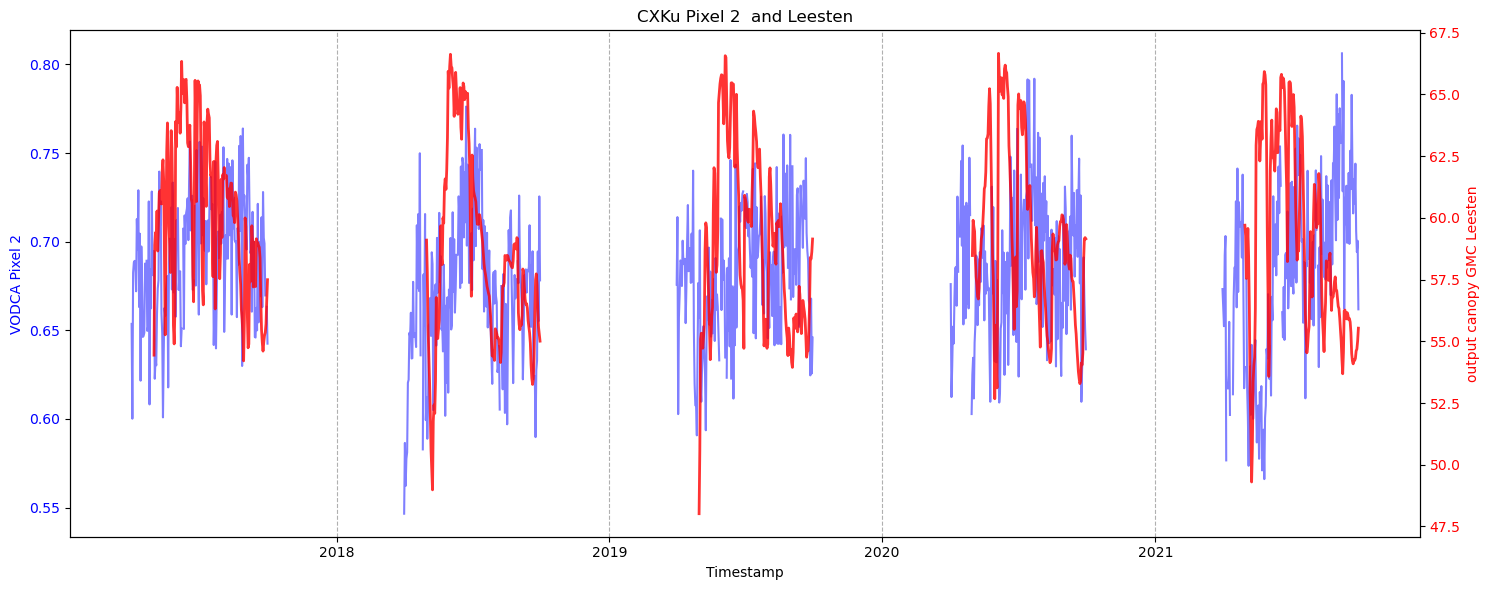

In [46]:
# CXKU & LEESTEN  all 5 years 

#VOD
CXKu_pixel__2_df = pd.DataFrame({
    "timestamp": time_steps_CXKu,
    "vodca_value": time_series_CXKu.get("Pixel2", np.array([]))
})

CXKu_pixel__2_df["timestamp"] = pd.to_datetime(CXKu_pixel__2_df["timestamp"])

CXku_pixel_2_filtered = CXKu_pixel__2_df[
    (CXKu_pixel__2_df["timestamp"].dt.year >= 2017) & 
    (CXKu_pixel__2_df["timestamp"].dt.year <= 2021) & 
    (CXKu_pixel__2_df["timestamp"].dt.month >= 4) & 
    (CXKu_pixel__2_df["timestamp"].dt.month < 10) 
]

#output
constrained_leesten["date"] = constrained_leesten["timestamp"].dt.date 
constrained_leesten_daily = (
    constrained_leesten.groupby("date")["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
constrained_leesten_daily["date"] = pd.to_datetime(constrained_leesten_daily["date"])

constrained_leesten_filtered = constrained_leesten_daily[
    (constrained_leesten_daily["date"].dt.year >= 2017) & 
    (constrained_leesten_daily["date"].dt.year <= 2021) & 
    (constrained_leesten_daily["date"].dt.month >= 4) & 
    (constrained_leesten_daily["date"].dt.month < 10)  # Excludes October 1st onward
]


# PLOT
fig, ax1 = plt.subplots(figsize=(15, 6))
plot_segmented_data(ax1, CXku_pixel_2_filtered, "timestamp", "vodca_value", 
                    label="CXKu Pixel 2", color="blue", alpha=0.5, linewidth=1.5)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("VODCA Pixel 2", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.xaxis.set_major_locator(mdates.YearLocator())  
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2 = ax1.twinx()
plot_segmented_data(ax2, constrained_leesten_filtered, "date", "Constrained_Max_Average", 
                    label="output canopy GMC Leesten", color="red", alpha=0.8, linewidth=2)
ax2.set_ylabel("output canopy GMC Leesten", color="red")
ax2.tick_params(axis='y', labelcolor="red")
plt.title("CXKu Pixel 2  and Leesten")
fig.tight_layout()
ax1.grid(axis='x', linestyle='--')
ax2.grid(False) 
plt.show()


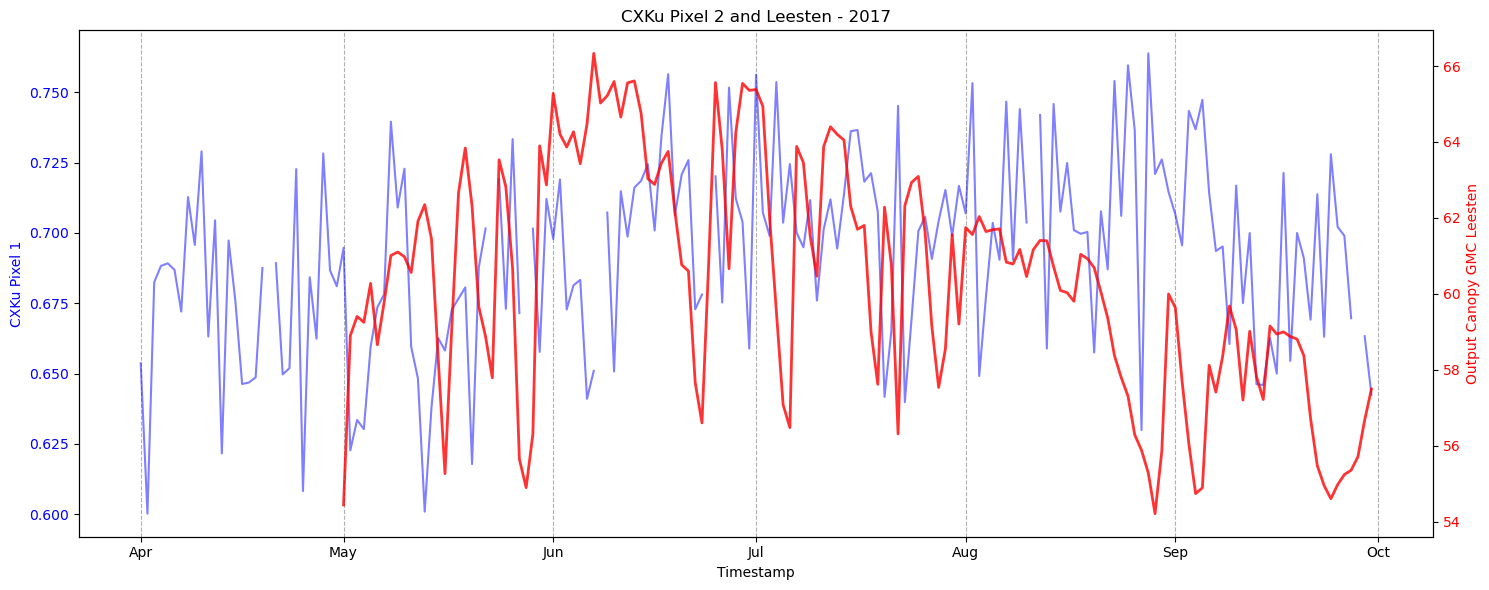

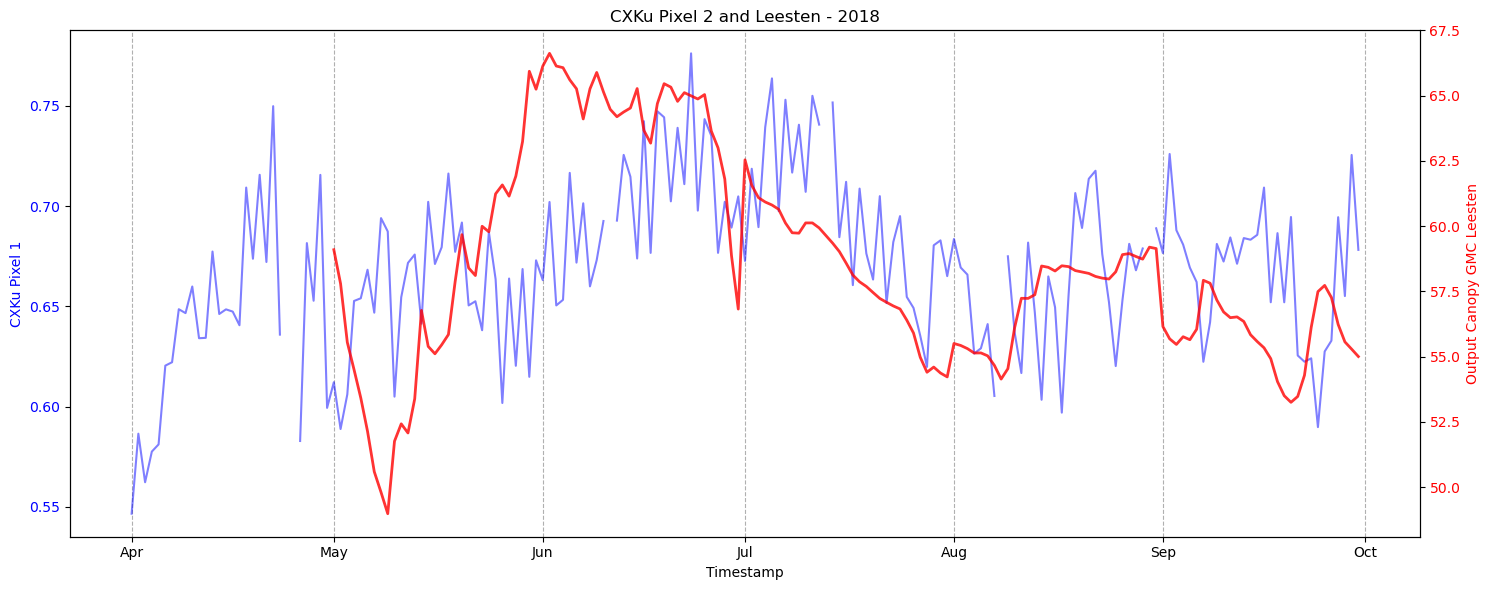

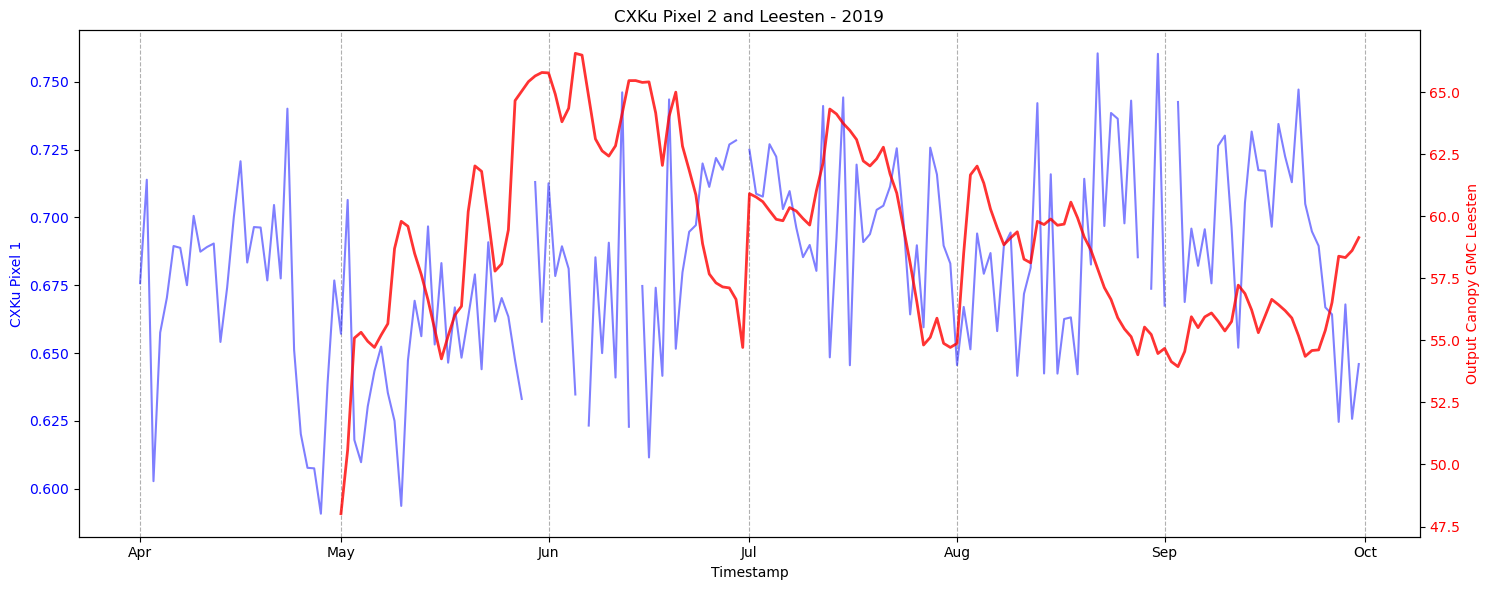

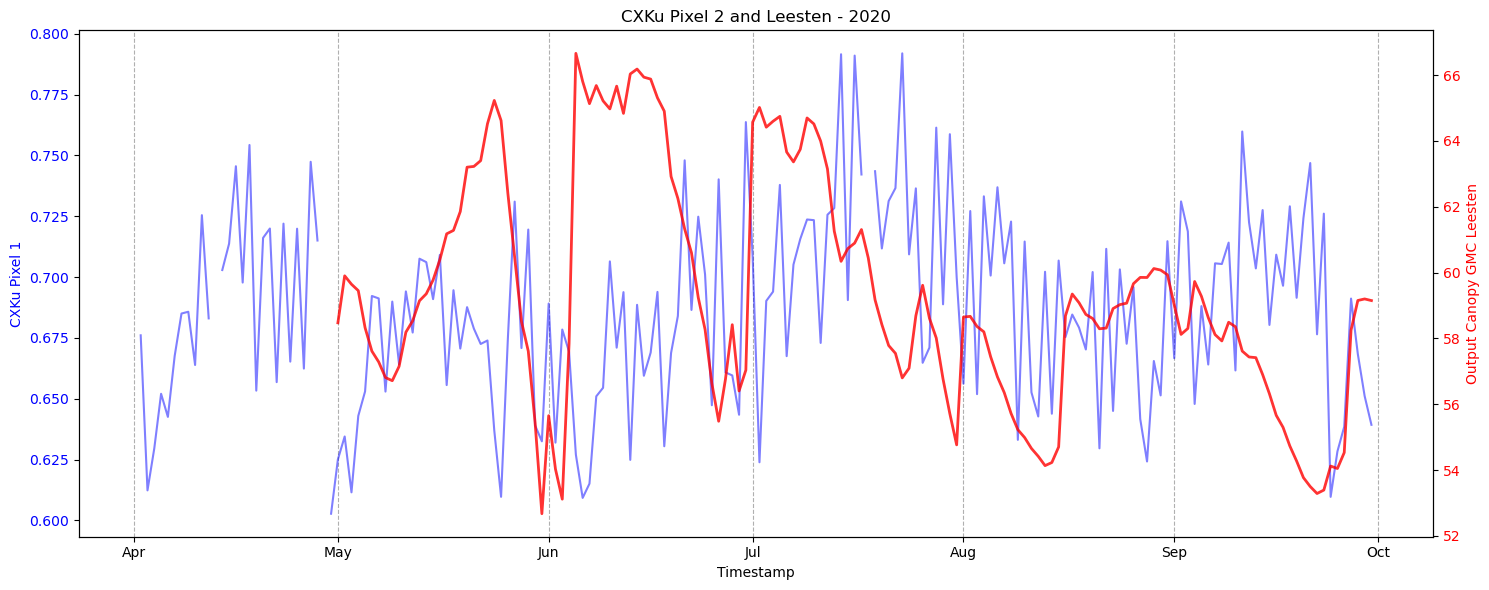

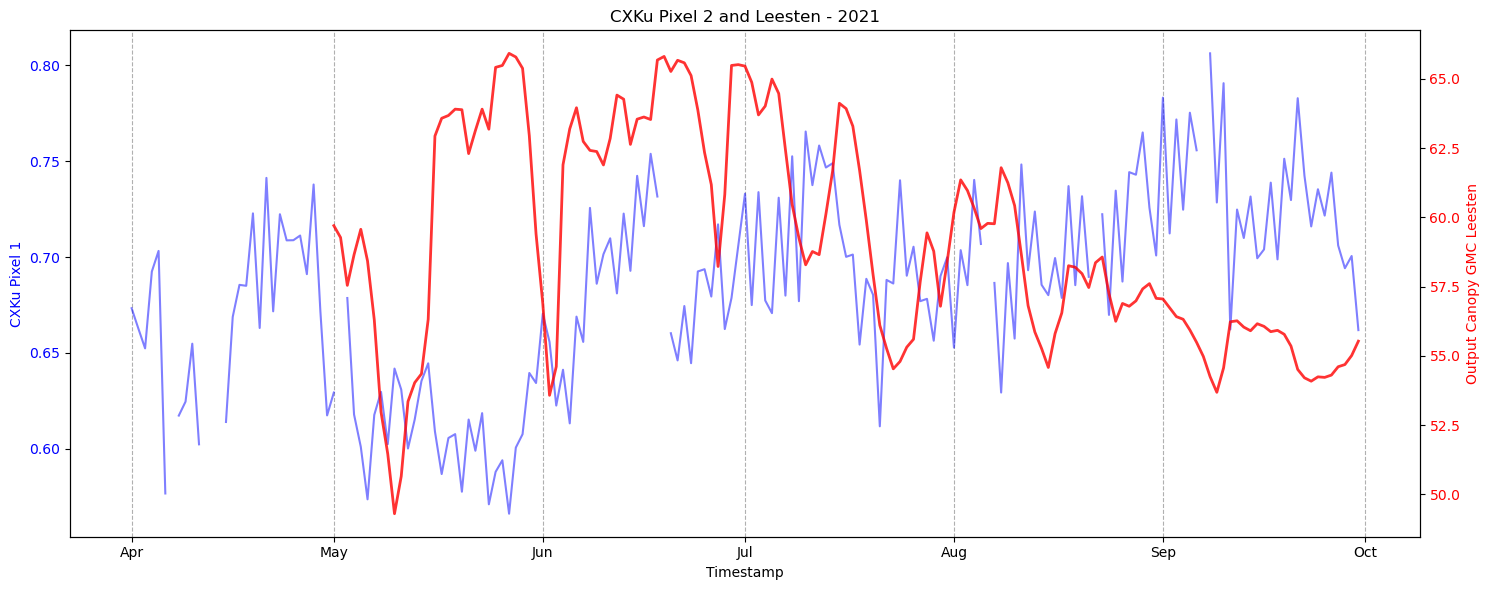

In [47]:
## Leesten + CXKu each year separated

for year in range(2017, 2022):
    CXKu_pixel_2_year = CXku_pixel_2_filtered[CXku_pixel_2_filtered["timestamp"].dt.year == year]
    constrained_leesten_year = constrained_leesten_filtered[constrained_leesten_filtered["date"].dt.year == year]

    fig, ax1 = plt.subplots(figsize=(15, 6))

    plot_segmented_data(ax1, CXKu_pixel_2_year, "timestamp", "vodca_value", 
                        label="CXKu Pixel 2", color="blue", alpha=0.5, linewidth=1.5)
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("CXKu Pixel 1", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b")) 
    ax2 = ax1.twinx()
    plot_segmented_data(ax2, constrained_leesten_year, "date", "Constrained_Max_Average", 
                        label="Output Canopy GMC Leesten", color="red", alpha=0.8, linewidth=2)
    ax2.set_ylabel("Output Canopy GMC Leesten", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    plt.title(f"CXKu Pixel 2 and Leesten - {year}")
    fig.tight_layout()
    ax1.grid(axis='x', linestyle='--') 
    ax2.grid(False)  
    plt.show()


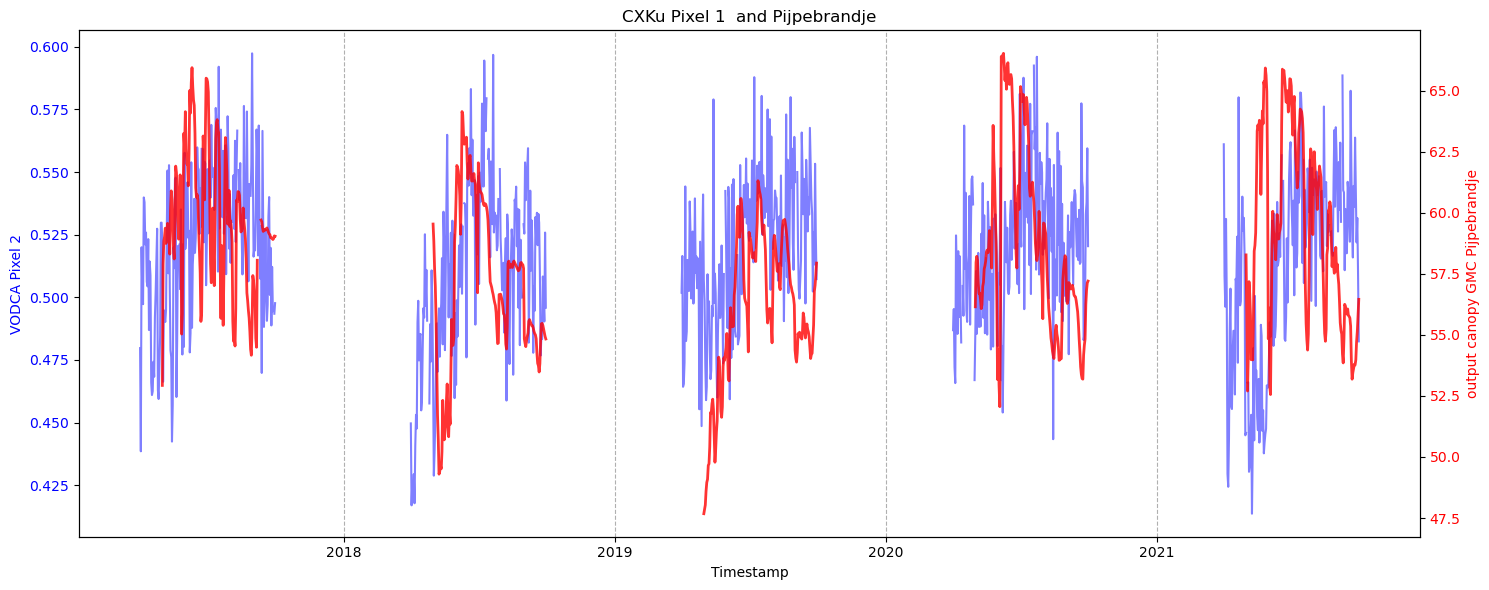

In [44]:
# CXKU & PIJPEBRANDHE  all 5 years 

#VOD
CXKu_pixel__1_df = pd.DataFrame({
    "timestamp": time_steps_CXKu,
    "vodca_value": time_series_CXKu.get("Pixel1", np.array([]))
})

CXKu_pixel__1_df["timestamp"] = pd.to_datetime(CXKu_pixel__1_df["timestamp"])

CXku_pixel_1_filtered = CXKu_pixel__1_df[
    (CXKu_pixel__1_df["timestamp"].dt.year >= 2017) & 
    (CXKu_pixel__1_df["timestamp"].dt.year <= 2021) & 
    (CXKu_pixel__1_df["timestamp"].dt.month >= 4) & 
    (CXKu_pixel__1_df["timestamp"].dt.month < 10) 
]

#output
constrained_pijpebrandje["date"] = constrained_pijpebrandje["timestamp"].dt.date 
constrained_pijpebrandje_daily = (
    constrained_pijpebrandje.groupby("date")["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
constrained_pijpebrandje_daily["date"] = pd.to_datetime(constrained_pijpebrandje_daily["date"])

constrained_pijpebrandje_filtered = constrained_pijpebrandje_daily[
    (constrained_pijpebrandje_daily["date"].dt.year >= 2017) & 
    (constrained_pijpebrandje_daily["date"].dt.year <= 2021) & 
    (constrained_pijpebrandje_daily["date"].dt.month >= 4) & 
    (constrained_pijpebrandje_daily["date"].dt.month < 10)  # Excludes October 1st onward
]


# PLOT
fig, ax1 = plt.subplots(figsize=(15, 6))
plot_segmented_data(ax1, CXku_pixel_1_filtered, "timestamp", "vodca_value", 
                    label="CXKu Pixel 2", color="blue", alpha=0.5, linewidth=1.5)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("VODCA Pixel 2", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.xaxis.set_major_locator(mdates.YearLocator())  
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax2 = ax1.twinx()
plot_segmented_data(ax2, constrained_pijpebrandje_filtered, "date", "Constrained_Max_Average", 
                    label="output canopy GMC Pijpebrandje", color="red", alpha=0.8, linewidth=2)
ax2.set_ylabel("output canopy GMC Pijpebrandje", color="red")
ax2.tick_params(axis='y', labelcolor="red")
plt.title("CXKu Pixel 1  and Pijpebrandje")
fig.tight_layout()
ax1.grid(axis='x', linestyle='--')
ax2.grid(False) 
plt.show()


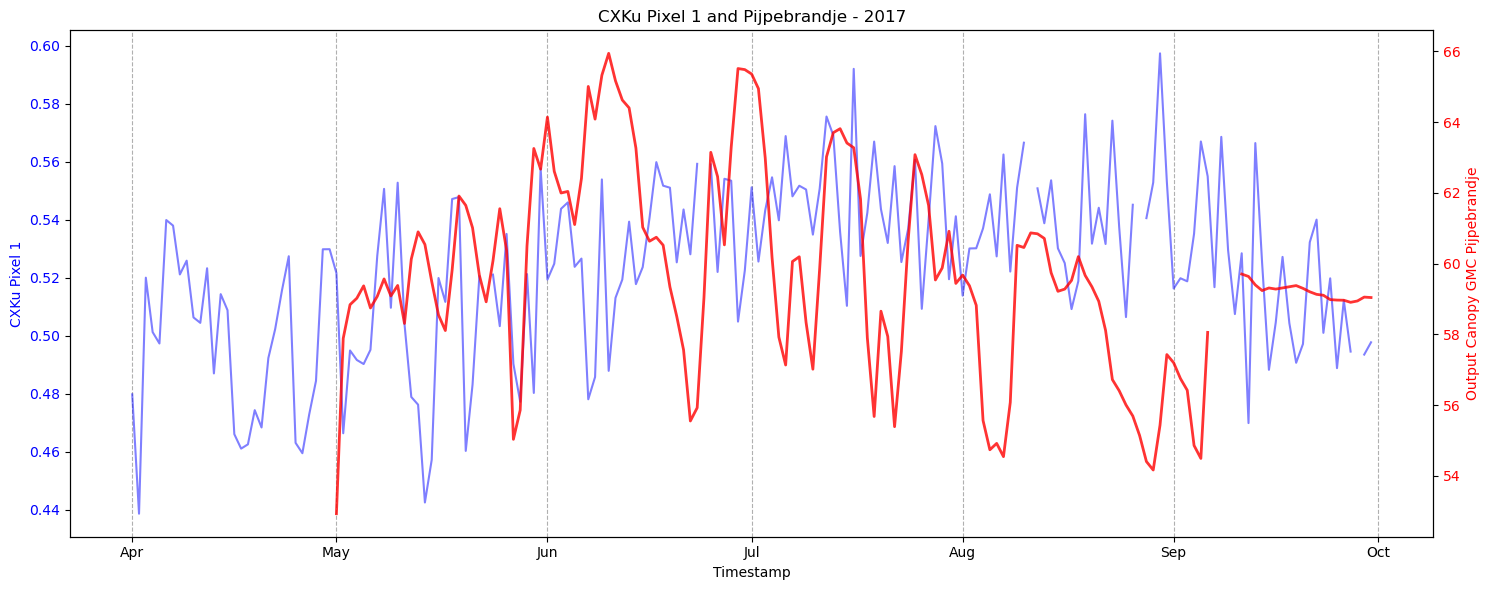

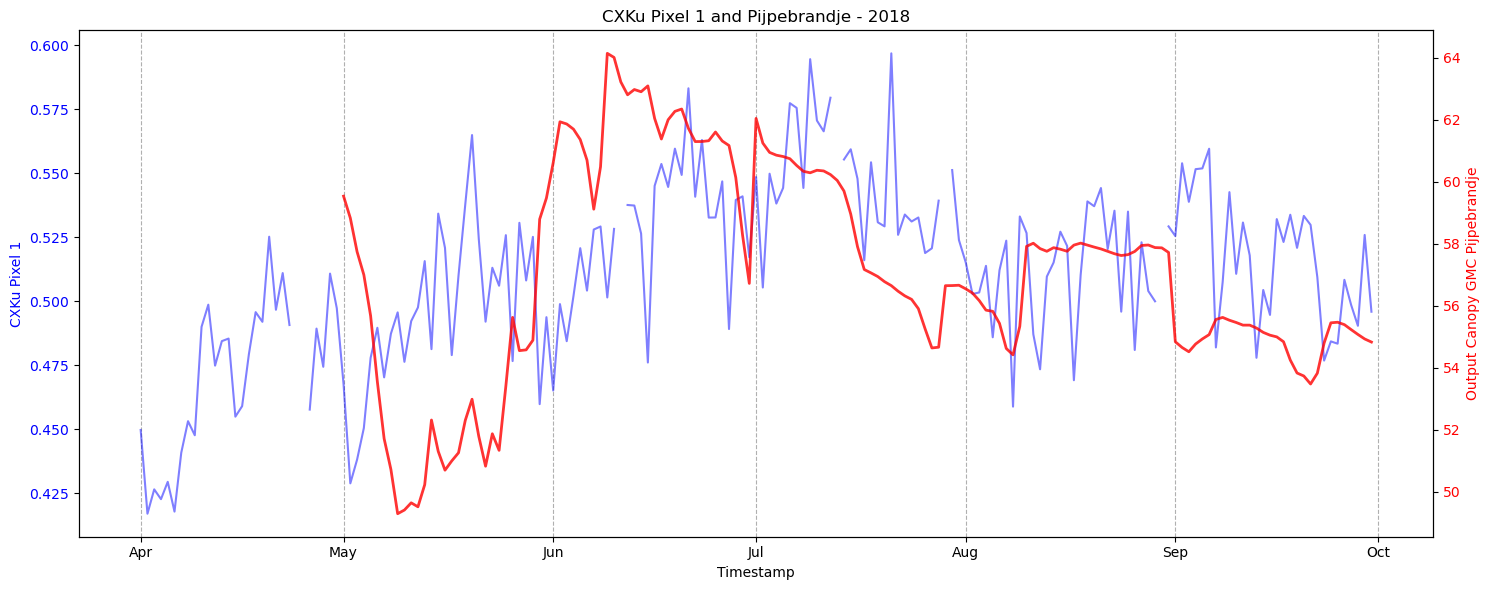

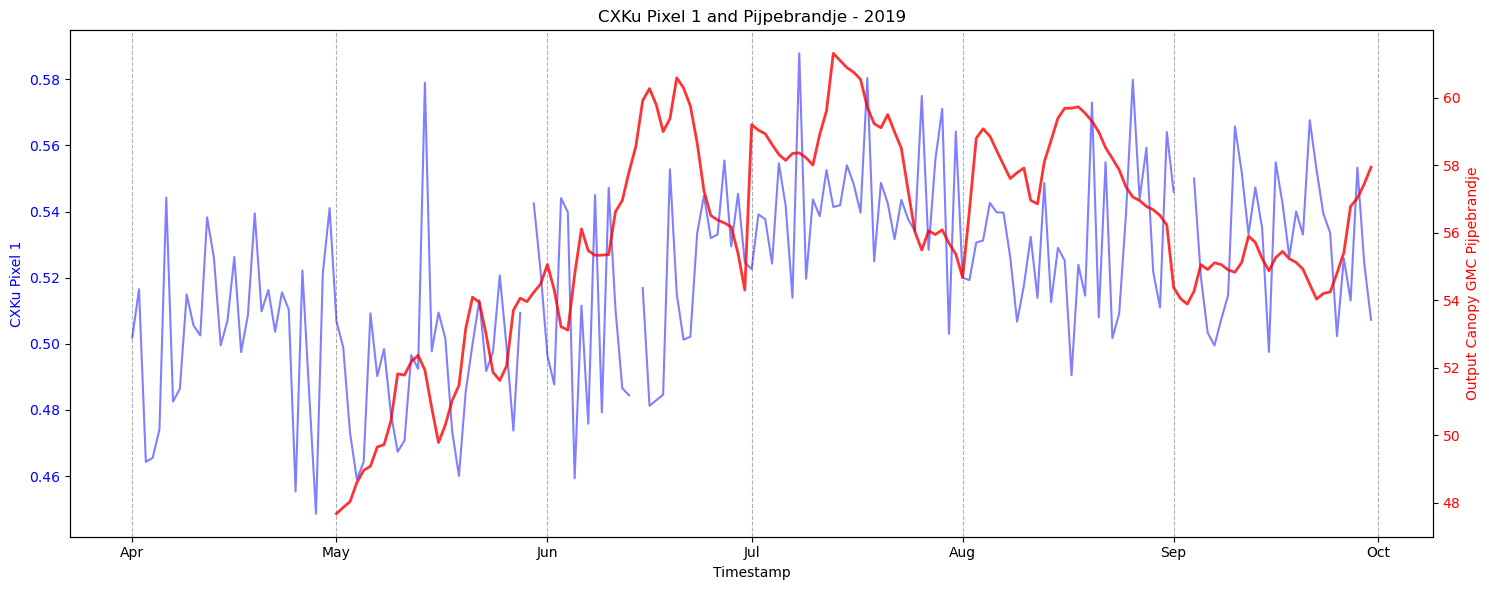

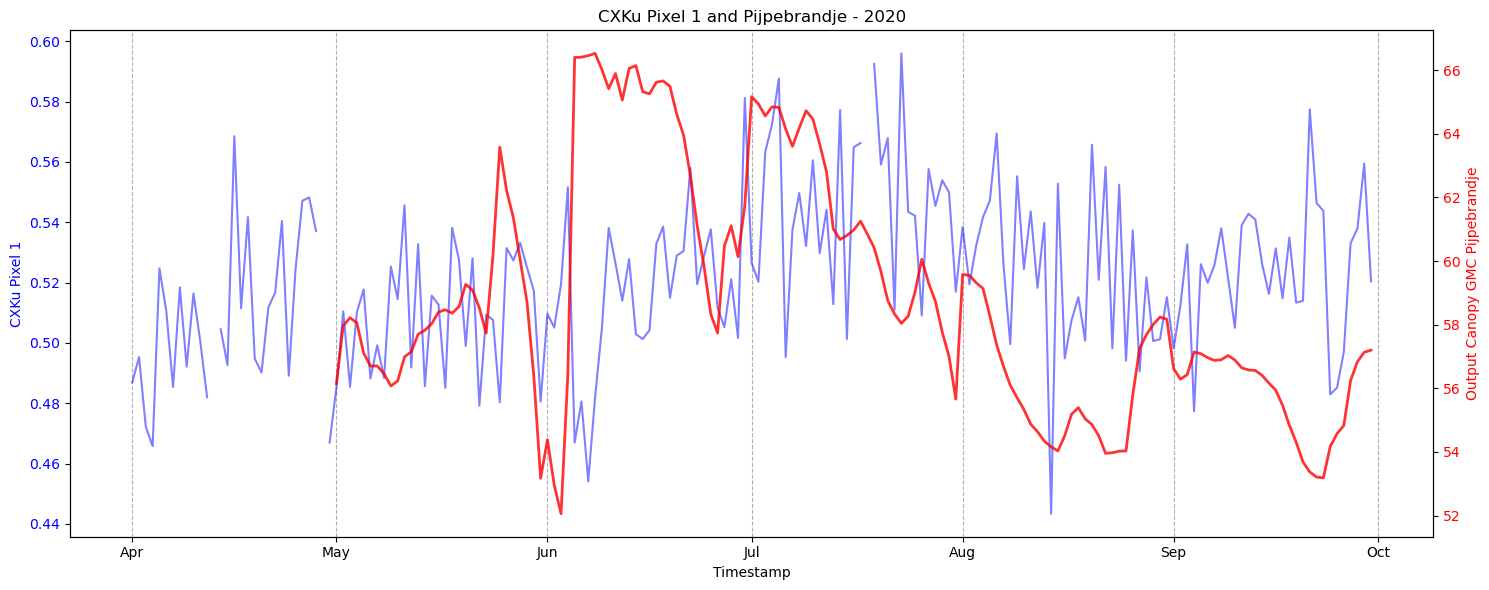

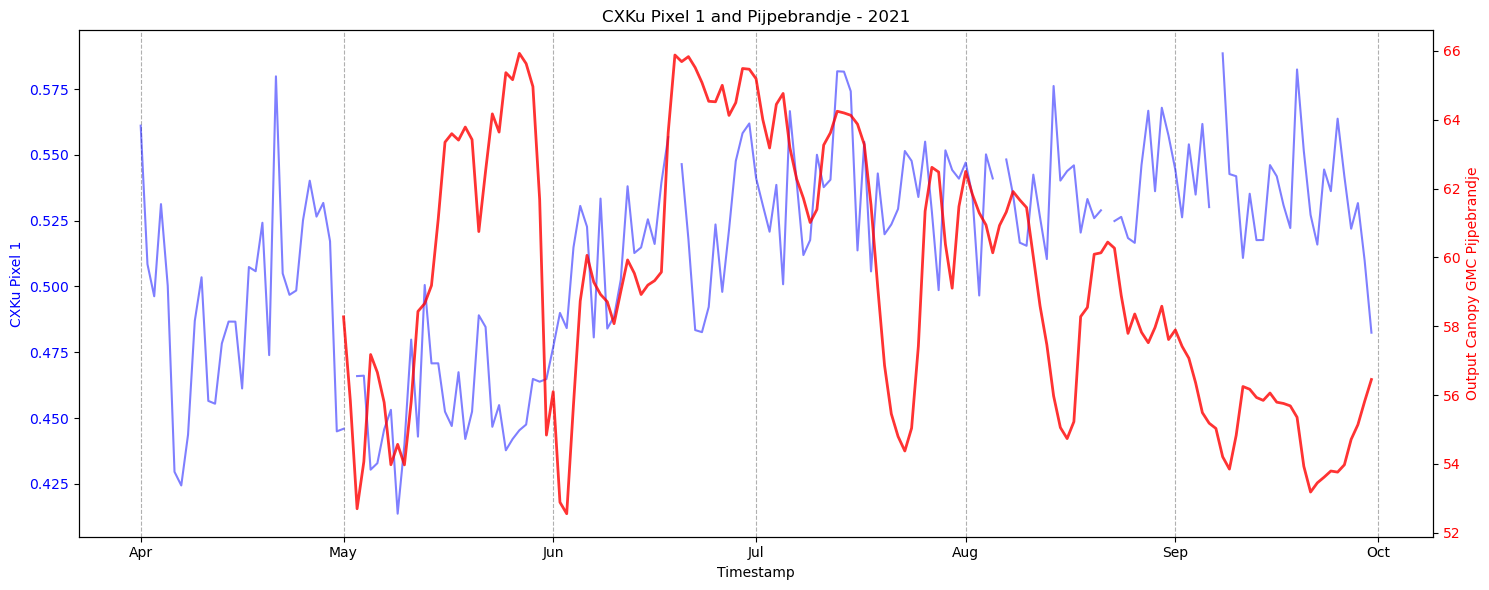

In [48]:
## Pijpebrandje + CXKu each year separated

for year in range(2017, 2022):
    CXKu_pixel_1_year = CXku_pixel_1_filtered[CXku_pixel_1_filtered["timestamp"].dt.year == year]
    constrained_pijpebrandje_year = constrained_pijpebrandje_filtered[constrained_pijpebrandje_filtered["date"].dt.year == year]

    fig, ax1 = plt.subplots(figsize=(15, 6))

    plot_segmented_data(ax1, CXKu_pixel_1_year, "timestamp", "vodca_value", 
                        label="CXKu Pixel 2", color="blue", alpha=0.5, linewidth=1.5)
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("CXKu Pixel 1", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b")) 
    ax2 = ax1.twinx()
    plot_segmented_data(ax2, constrained_pijpebrandje_year, "date", "Constrained_Max_Average", 
                        label="Output Canopy GMC Pijpebrandje", color="red", alpha=0.8, linewidth=2)
    ax2.set_ylabel("Output Canopy GMC Pijpebrandje", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    plt.title(f"CXKu Pixel 1 and Pijpebrandje - {year}")
    fig.tight_layout()
    ax1.grid(axis='x', linestyle='--') 
    ax2.grid(False)  
    plt.show()


### 6.2. L-band VOD

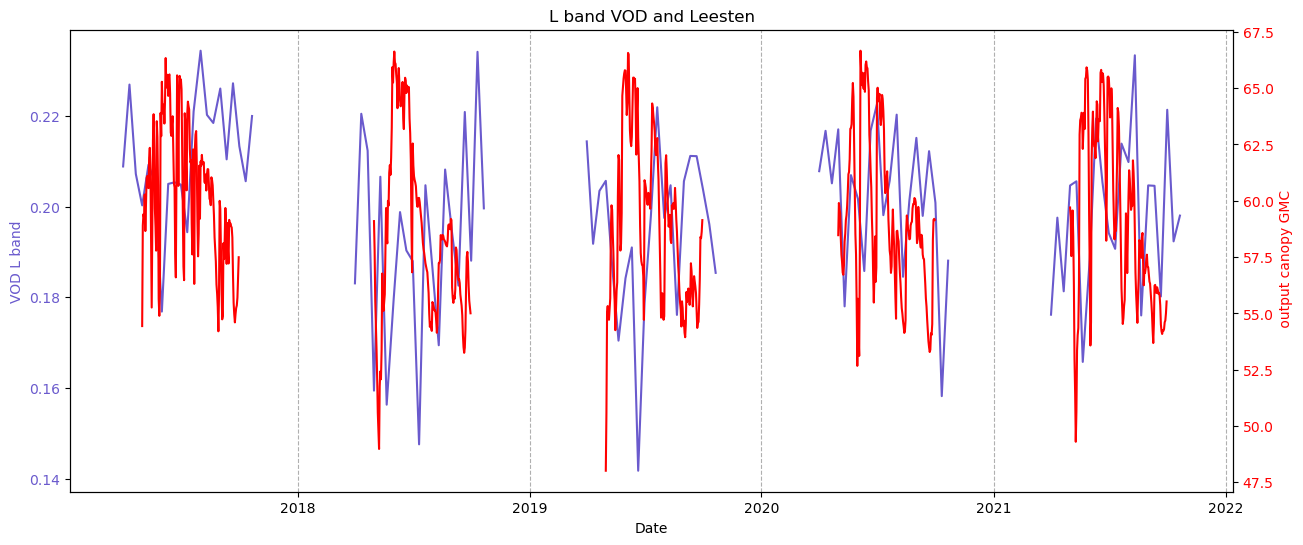

In [ ]:
# LEESTEN

color1='slateblue'
color2='red'

L_pixel__2_df = pd.DataFrame({
    "timestamp": time_steps_L, 
    "vodca_value": timeseries_pixel_2_L  
})

L_pixel__2_df["timestamp"] = pd.to_datetime(L_pixel__2_df["timestamp"])
constrained_leesten["timestamp"] = pd.to_datetime(constrained_leesten["timestamp"])
L_pixel__2_df_filtered = L_pixel__2_df[
    (L_pixel__2_df["timestamp"].dt.month >= 4) & (L_pixel__2_df["timestamp"].dt.month <= 10)
]

constrained_leesten_daily = (
    constrained_leesten.groupby(constrained_leesten["timestamp"].dt.date)["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
constrained_leesten_daily["timestamp"] = pd.to_datetime(constrained_leesten_daily["timestamp"])
constrained_leesten_daily_filtered = constrained_leesten_daily[
    (constrained_leesten_daily["timestamp"].dt.month >= 4) & (constrained_leesten_daily["timestamp"].dt.month <= 10)
]

# plot
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_xlabel("Date")
ax1.set_ylabel("VOD L band", color=color1)
for year in L_pixel__2_df_filtered["timestamp"].dt.year.unique():
    subset = L_pixel__2_df_filtered[L_pixel__2_df_filtered["timestamp"].dt.year == year]
    ax1.plot(subset["timestamp"], subset["vodca_value"], color=color1,linestyle="-", label=f"vodca_value {year}")
ax1.tick_params(axis="y", labelcolor=color1)
ax2 = ax1.twinx()
ax2.set_ylabel(" output canopy GMC", color=color2)
for year in constrained_leesten_daily_filtered["timestamp"].dt.year.unique():
    subset = constrained_leesten_daily_filtered[constrained_leesten_daily_filtered["timestamp"].dt.year == year]
    ax2.plot(subset["timestamp"], subset["Constrained_Max_Average"], color=color2, linestyle="-", label=f"Constrained_Max_Average {year}")
ax2.tick_params(axis="y", labelcolor=color2)
ax1.grid(axis='x', linestyle='--') 
ax2.grid(False)  
plt.title("L band VOD and Leesten")
plt.show()


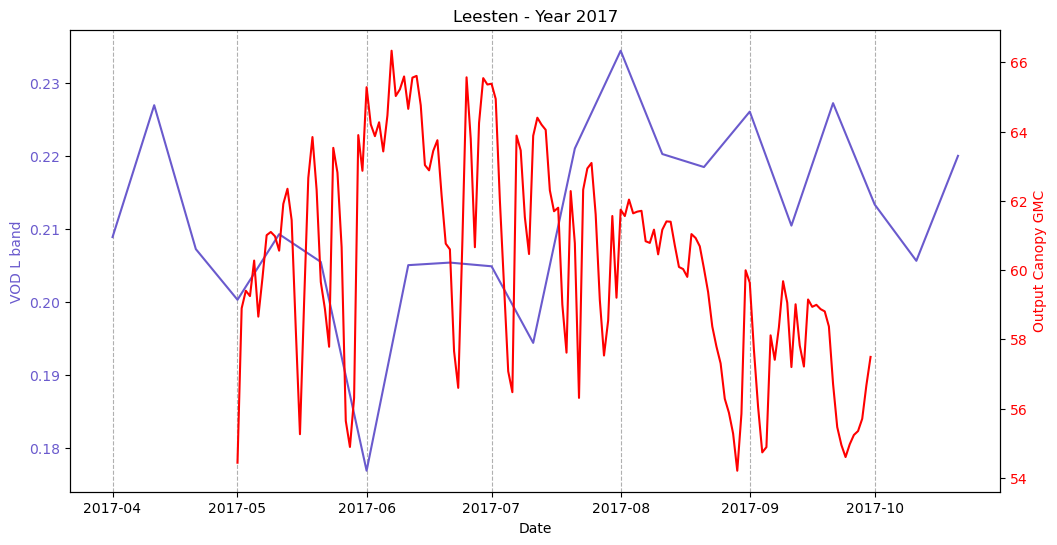

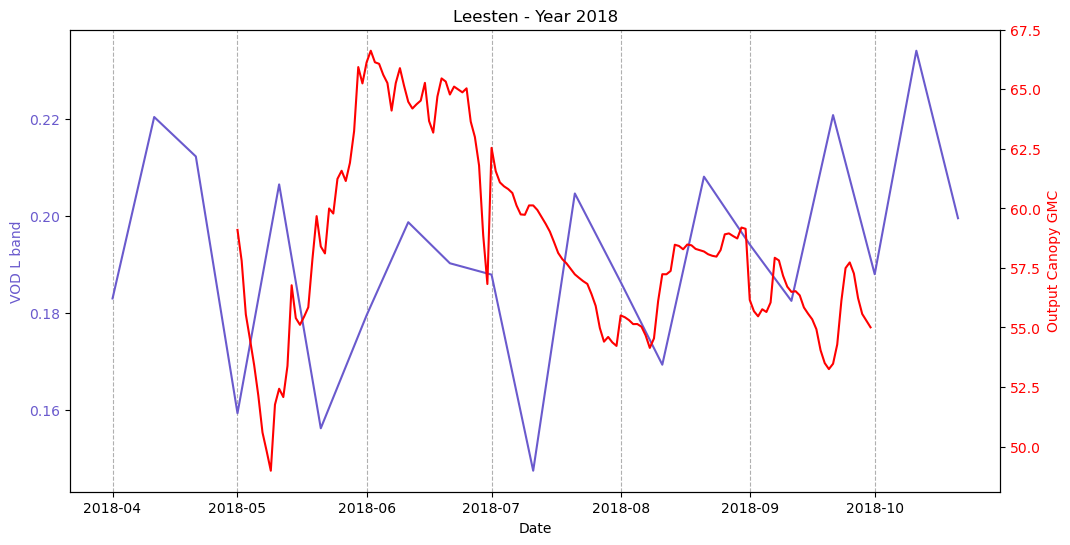

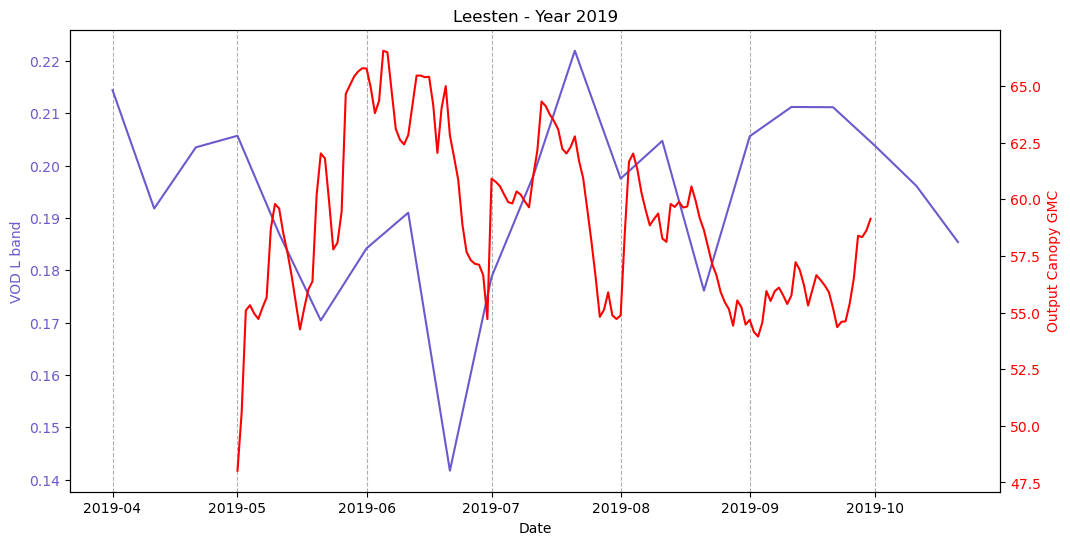

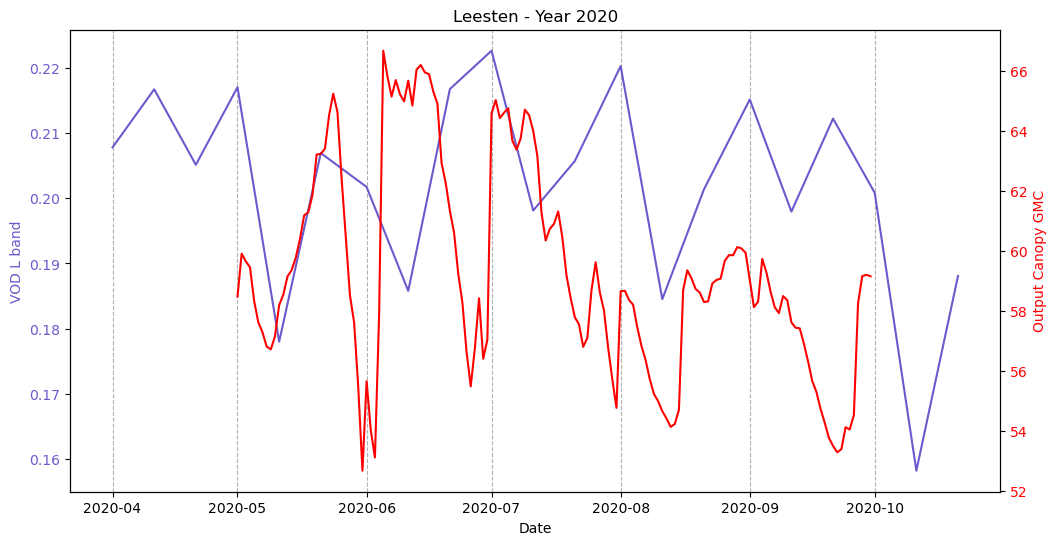

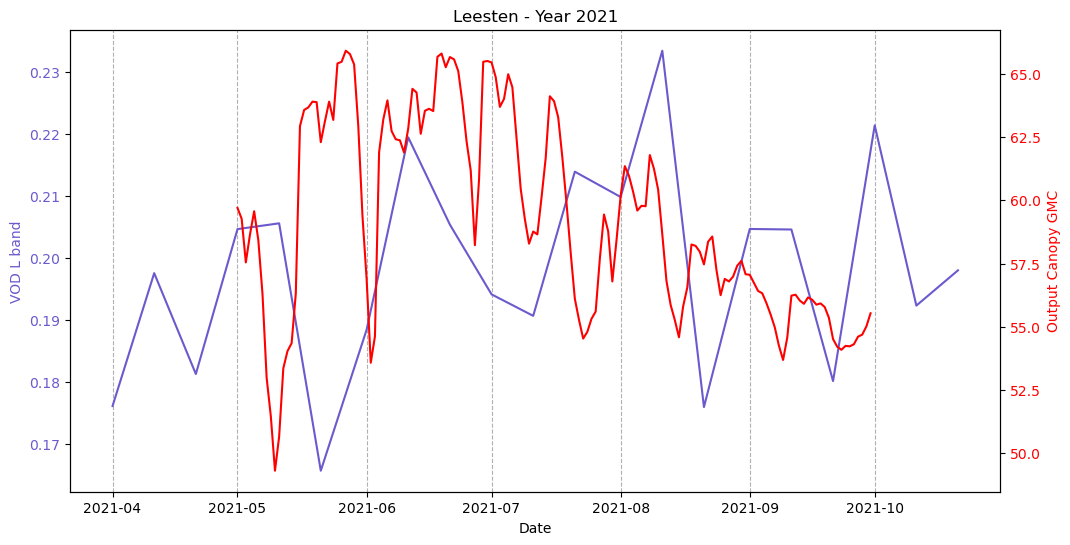

In [60]:
# Leesten and L separated

L_pixel__2_df["timestamp"] = pd.to_datetime(L_pixel__2_df["timestamp"])
constrained_leesten["timestamp"] = pd.to_datetime(constrained_leesten["timestamp"])
L_pixel__2_df_filtered = L_pixel__2_df[
    (L_pixel__2_df["timestamp"].dt.month >= 4) & (L_pixel__2_df["timestamp"].dt.month <= 10)
]

daily_constrained = (
    constrained_leesten.groupby(constrained_leesten["timestamp"].dt.date)["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
daily_constrained["timestamp"] = pd.to_datetime(daily_constrained["timestamp"])
daily_constrained_filtered = daily_constrained[
    (daily_constrained["timestamp"].dt.month >= 4) & (daily_constrained["timestamp"].dt.month <= 10)
]

years = sorted(set(L_pixel__2_df_filtered["timestamp"].dt.year) & set(daily_constrained_filtered["timestamp"].dt.year))

for year in years:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    subset_vodca = L_pixel__2_df_filtered[L_pixel__2_df_filtered["timestamp"].dt.year == year]
    ax1.set_xlabel("Date")
    ax1.set_ylabel("VOD L band", color=color1)
    ax1.plot(subset_vodca["timestamp"], subset_vodca["vodca_value"], color=color1, linestyle="-", label="VOD L band")
    ax1.tick_params(axis="y", labelcolor=color1)
    ax2 = ax1.twinx()
    subset_constrained = daily_constrained_filtered[daily_constrained_filtered["timestamp"].dt.year == year]
    ax2.set_ylabel("Output Canopy GMC", color=color2)
    ax2.plot(subset_constrained["timestamp"], subset_constrained["Constrained_Max_Average"], color=color2, linestyle="-", label="Output canopy GMC")
    ax2.tick_params(axis="y", labelcolor=color2)
    plt.title(f"Leesten - Year {year}")
    ax1.grid(axis='x', linestyle='--')  
    ax2.grid(False)
    plt.show()


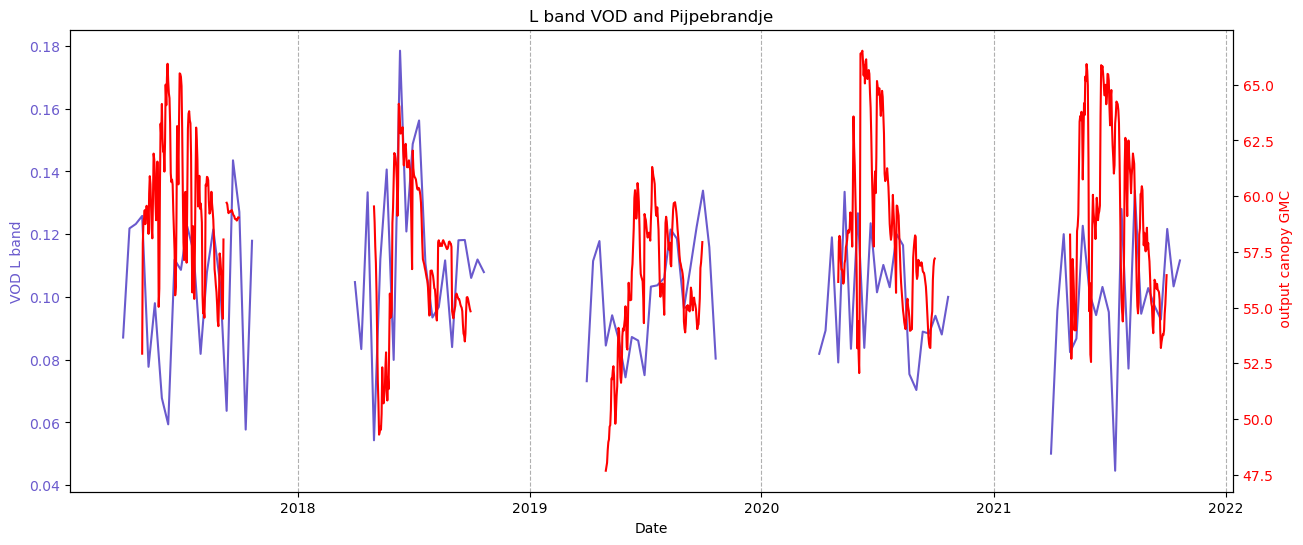

In [57]:
#Pijpebdranje 

L_pixel__1_df = pd.DataFrame({
    "timestamp": time_steps_L, 
    "vodca_value": timeseries_pixel_1_L  
})

L_pixel__1_df["timestamp"] = pd.to_datetime(L_pixel__1_df["timestamp"])
constrained_pijpebrandje["timestamp"] = pd.to_datetime(constrained_pijpebrandje["timestamp"])
L_pixel__1_df_filtered = L_pixel__1_df[
    (L_pixel__1_df["timestamp"].dt.month >= 4) & (L_pixel__1_df["timestamp"].dt.month <= 10)
]

constrained_pijpebrandje_daily = (
    constrained_pijpebrandje.groupby(constrained_pijpebrandje["timestamp"].dt.date)["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
constrained_pijpebrandje_daily["timestamp"] = pd.to_datetime(constrained_pijpebrandje_daily["timestamp"])
constrained_pijpebrandje_filtered = constrained_pijpebrandje_daily[
    (constrained_pijpebrandje_daily["timestamp"].dt.month >= 4) & (constrained_pijpebrandje_daily["timestamp"].dt.month <= 10)
]

# plot
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_xlabel("Date")
ax1.set_ylabel("VOD L band", color=color1)
for year in L_pixel__1_df_filtered["timestamp"].dt.year.unique():
    subset = L_pixel__1_df_filtered[L_pixel__1_df_filtered["timestamp"].dt.year == year]
    ax1.plot(subset["timestamp"], subset["vodca_value"], color=color1,linestyle="-", label=f"vodca_value {year}")
ax1.tick_params(axis="y", labelcolor=color1)
ax2 = ax1.twinx()
ax2.set_ylabel(" output canopy GMC", color=color2)
for year in constrained_pijpebrandje_filtered["timestamp"].dt.year.unique():
    subset = constrained_pijpebrandje_filtered[constrained_pijpebrandje_filtered["timestamp"].dt.year == year]
    ax2.plot(subset["timestamp"], subset["Constrained_Max_Average"], color=color2, linestyle="-", label=f"Constrained_Max_Average {year}")
ax2.tick_params(axis="y", labelcolor=color2)
ax1.grid(axis='x', linestyle='--') 
ax2.grid(False)  
plt.title("L band VOD and Pijpebrandje")
plt.show()


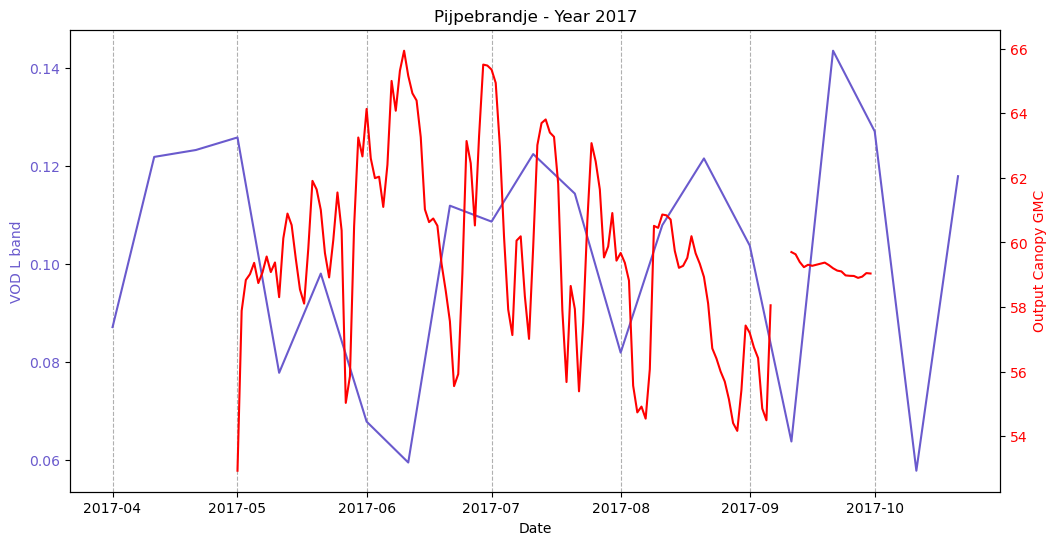

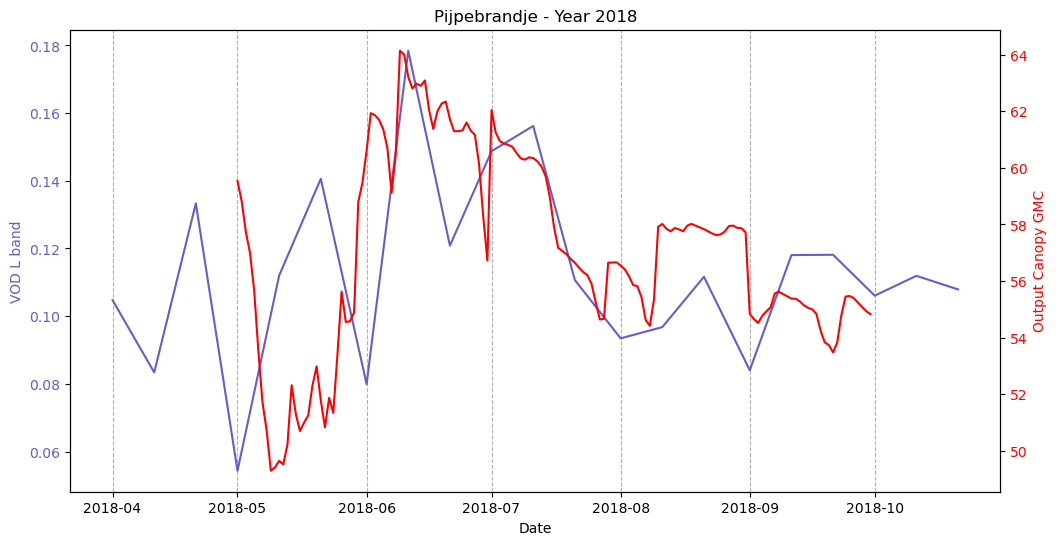

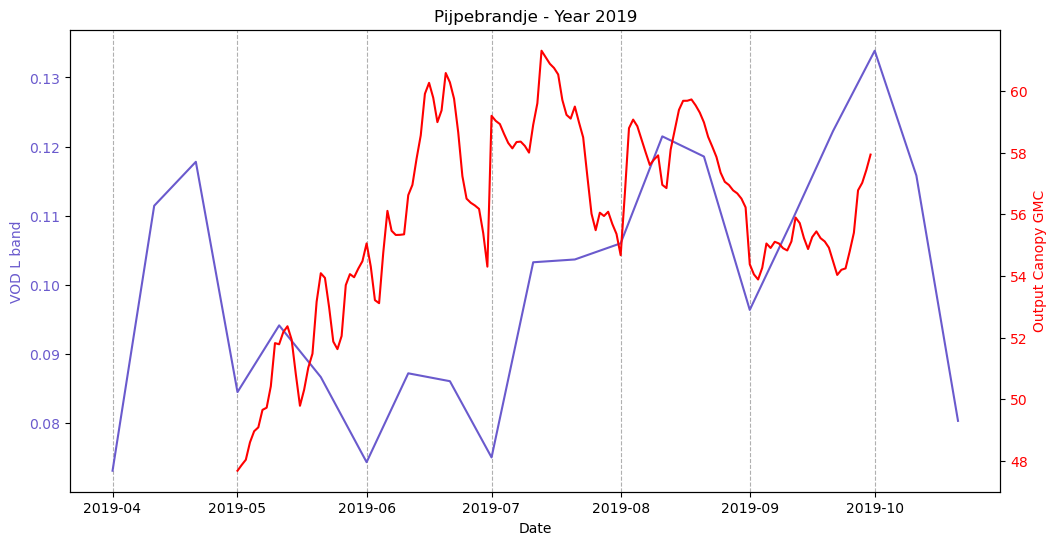

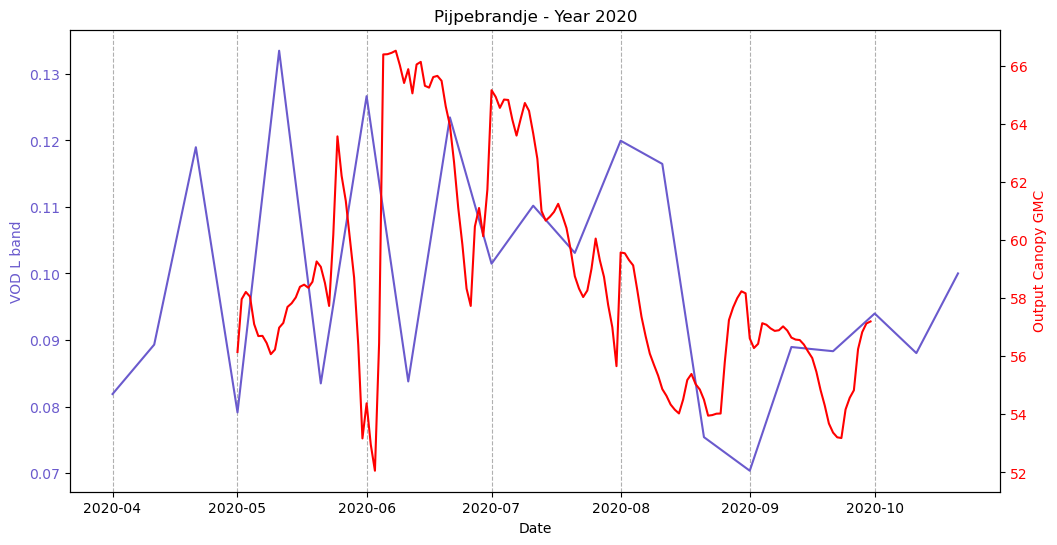

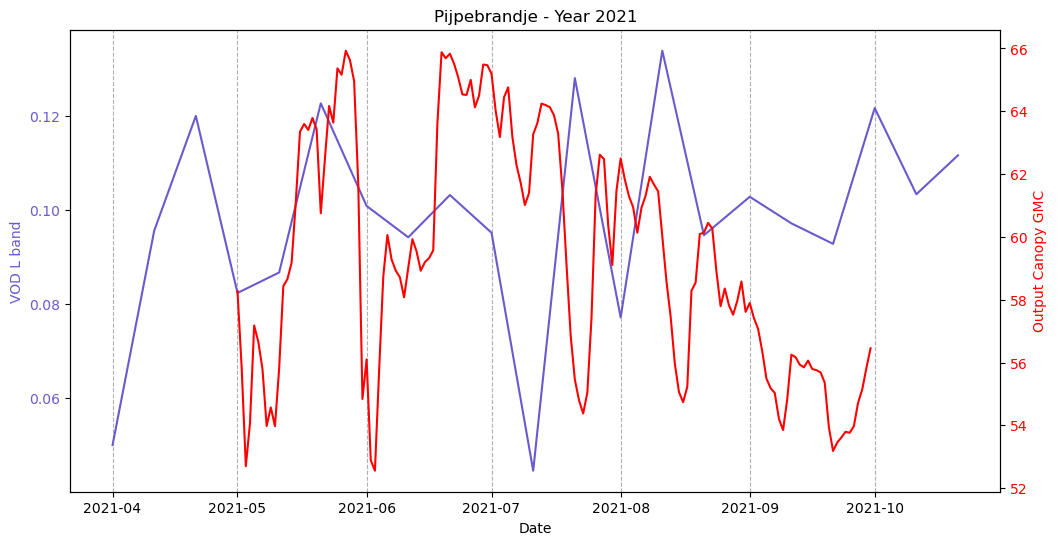

In [59]:
# Pijpebrandje and L separated

L_pixel__1_df["timestamp"] = pd.to_datetime(L_pixel__1_df["timestamp"])
constrained_pijpebrandje["timestamp"] = pd.to_datetime(constrained_pijpebrandje["timestamp"])
L_pixel__1_df_filtered = L_pixel__1_df[
    (L_pixel__1_df["timestamp"].dt.month >= 4) & (L_pixel__1_df["timestamp"].dt.month <= 10)
]

daily_constrained = (
    constrained_pijpebrandje.groupby(constrained_pijpebrandje["timestamp"].dt.date)["Constrained_Max_Average"]
    .mean()
    .reset_index()
)
daily_constrained["timestamp"] = pd.to_datetime(daily_constrained["timestamp"])
daily_constrained_filtered = daily_constrained[
    (daily_constrained["timestamp"].dt.month >= 4) & (daily_constrained["timestamp"].dt.month <= 10)
]

years = sorted(set(L_pixel__1_df_filtered["timestamp"].dt.year) & set(daily_constrained_filtered["timestamp"].dt.year))

for year in years:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    subset_vodca = L_pixel__1_df_filtered[L_pixel__1_df_filtered["timestamp"].dt.year == year]
    ax1.set_xlabel("Date")
    ax1.set_ylabel("VOD L band", color=color1)
    ax1.plot(subset_vodca["timestamp"], subset_vodca["vodca_value"], color=color1, linestyle="-", label="VOD L band")
    ax1.tick_params(axis="y", labelcolor=color1)
    ax2 = ax1.twinx()
    subset_constrained = daily_constrained_filtered[daily_constrained_filtered["timestamp"].dt.year == year]
    ax2.set_ylabel("Output Canopy GMC", color=color2)
    ax2.plot(subset_constrained["timestamp"], subset_constrained["Constrained_Max_Average"], color=color2, linestyle="-", label="Output canopy GMC")
    ax2.tick_params(axis="y", labelcolor=color2)
    plt.title(f"Pijpebrandje - Year {year}")
    ax1.grid(axis='x', linestyle='--')  
    ax2.grid(False)
    plt.show()


# 7. Plot weekly averages + spearman corr

### 7.1. CXKU

/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_4473/1279139396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CXku_pixel_2_filtered["timestamp"] = pd.to_datetime(CXku_pixel_2_filtered["timestamp"])


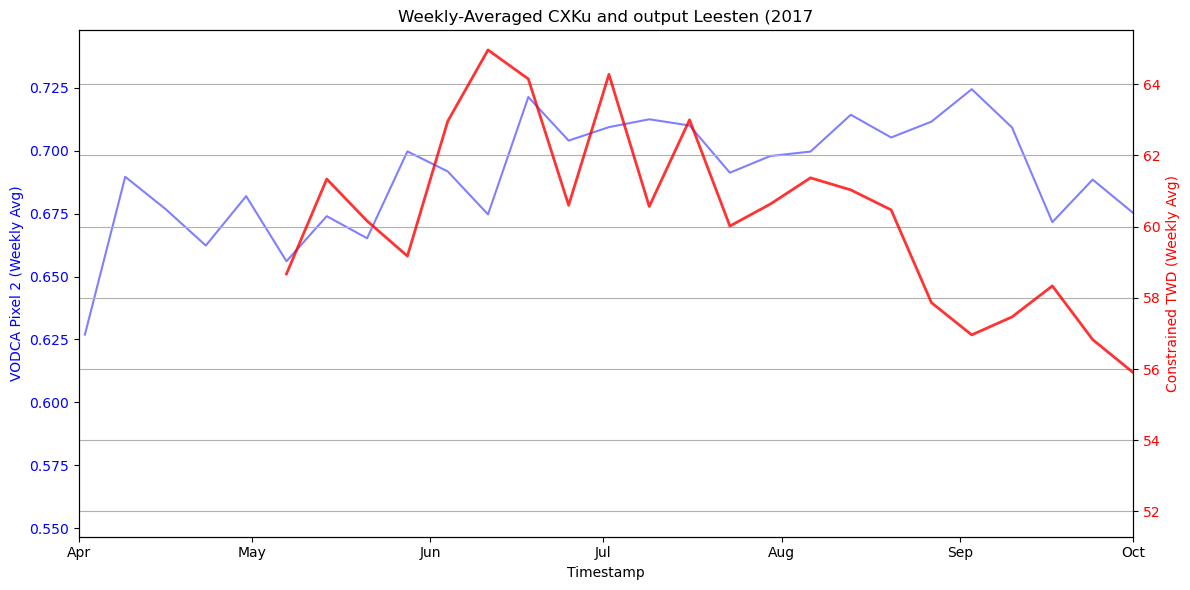

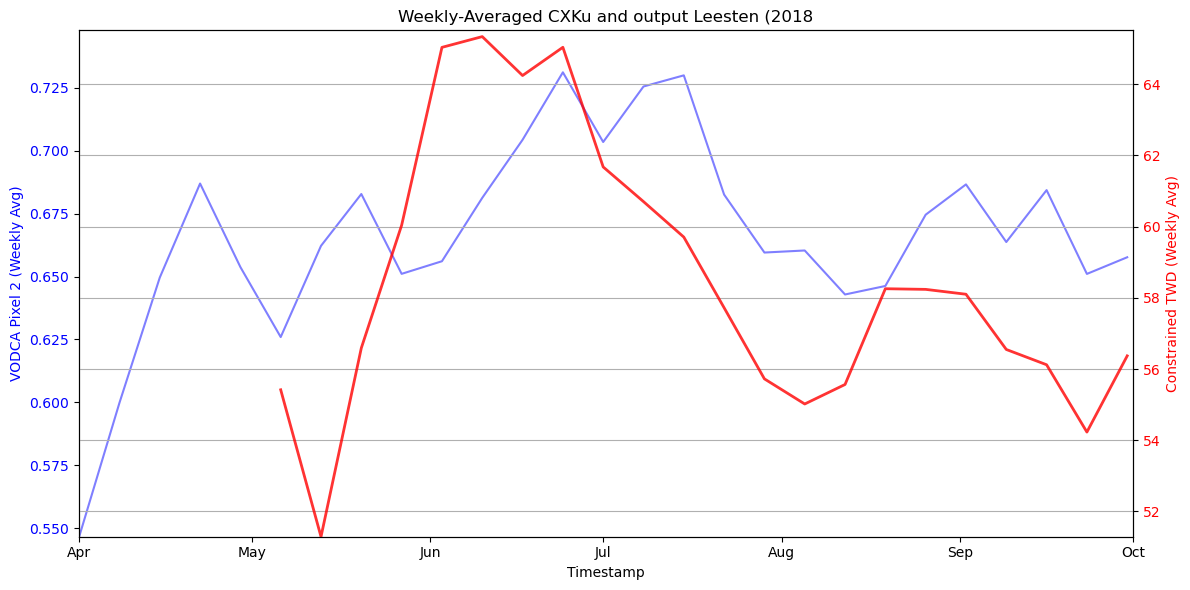

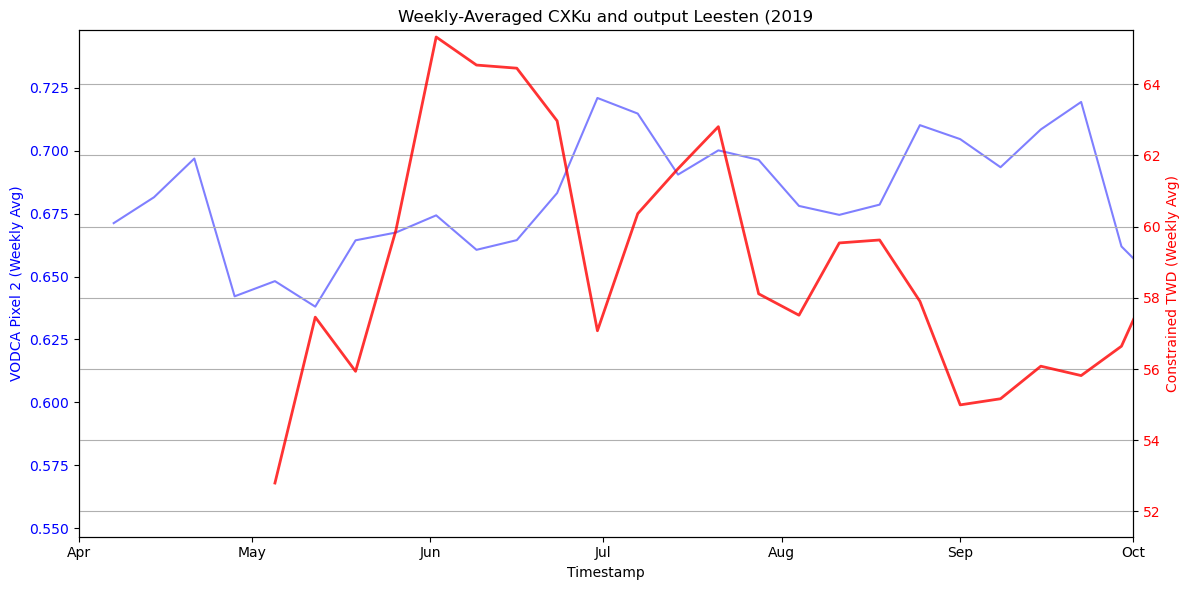

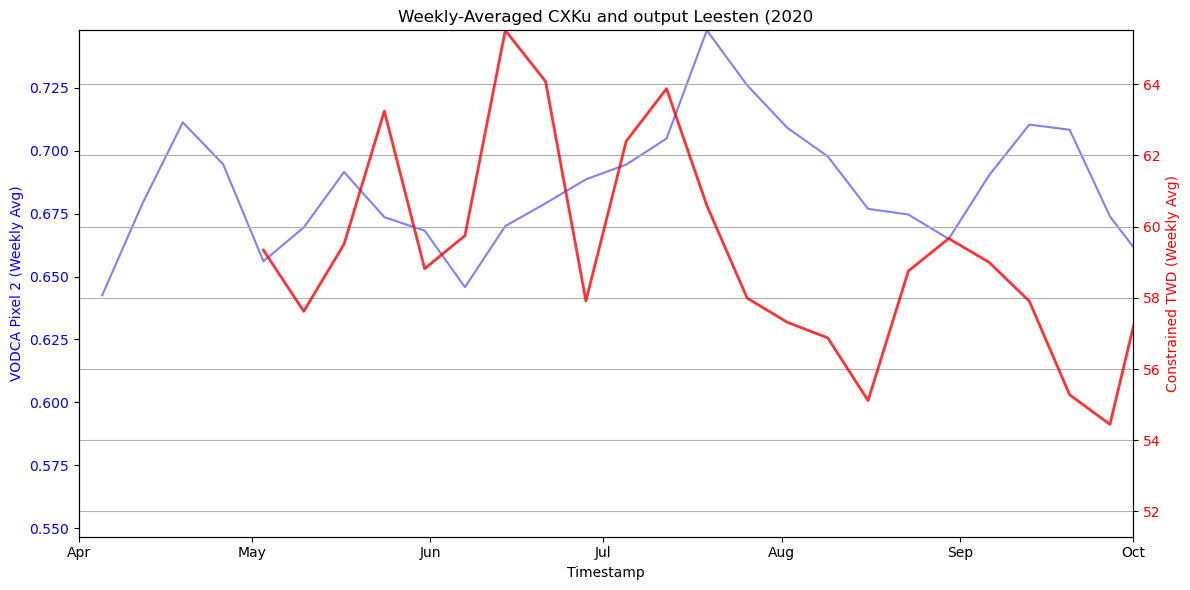

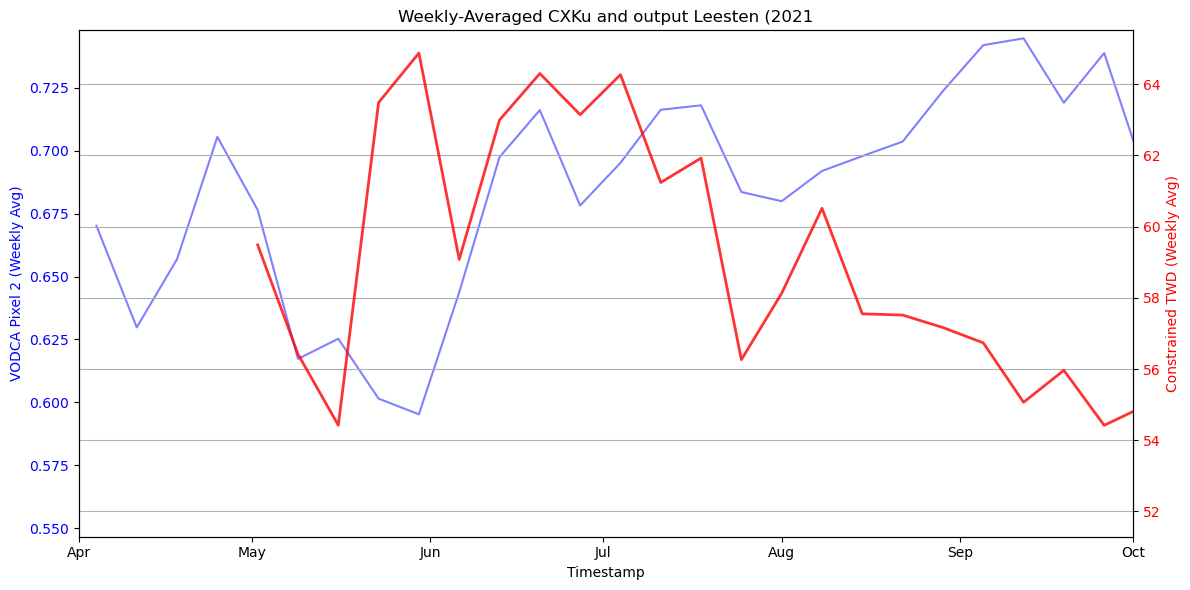

In [63]:
#Leesten
years = range(2017, 2022) 

CXku_pixel_2_filtered["timestamp"] = pd.to_datetime(CXku_pixel_2_filtered["timestamp"])
constrained_leesten_daily["timestamp"] = pd.to_datetime(constrained_leesten_daily["timestamp"])

vodca_weekly = CXku_pixel_2_filtered.set_index("timestamp").resample("W").mean().reset_index()

constrained_leesten_weekly = constrained_leesten_daily.set_index("timestamp").resample("W").mean().reset_index()
vodca_min, vodca_max = vodca_weekly["vodca_value"].min(), vodca_weekly["vodca_value"].max()
constrained_min, constrained_max = constrained_leesten_weekly["Constrained_Max_Average"].min(), constrained_leesten_weekly["Constrained_Max_Average"].max()

for year in years:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    vodca_filtered_year = vodca_weekly[vodca_weekly["timestamp"].dt.year == year]
    constrained_leesten_filtered_year = constrained_leesten_weekly[constrained_leesten_weekly["timestamp"].dt.year == year]
    ax1.plot(vodca_filtered_year["timestamp"], vodca_filtered_year["vodca_value"], 
             linestyle='-', color="blue", alpha=0.5, linewidth=1.5, label="VODCA Pixel 2 (Weekly Avg)")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("VODCA Pixel 2 (Weekly Avg)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_ylim(vodca_min, vodca_max)
    ax2 = ax1.twinx()
    ax2.plot(constrained_leesten_filtered_year["timestamp"], constrained_leesten_filtered_year["Constrained_Max_Average"], 
             linestyle='-', color="red", alpha=0.8, linewidth=2, label="Constrained TWD (Weekly Avg)")
    ax2.set_ylabel("Constrained TWD (Weekly Avg)", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.set_ylim(constrained_min, constrained_max)
    plt.title(f"Weekly-Averaged CXKu and output Leesten ({year}")
    fig.tight_layout()
    plt.grid(True)
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax1.set_xlim(pd.Timestamp(f"{year}-04-01"), pd.Timestamp(f"{year}-10-01"))
    plt.show()


/var/folders/0j/0ng55b7x7s99l0xjltdn28_h0000gn/T/ipykernel_4473/2266739314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CXku_pixel_1_filtered["timestamp"] = pd.to_datetime(CXku_pixel_1_filtered["timestamp"])


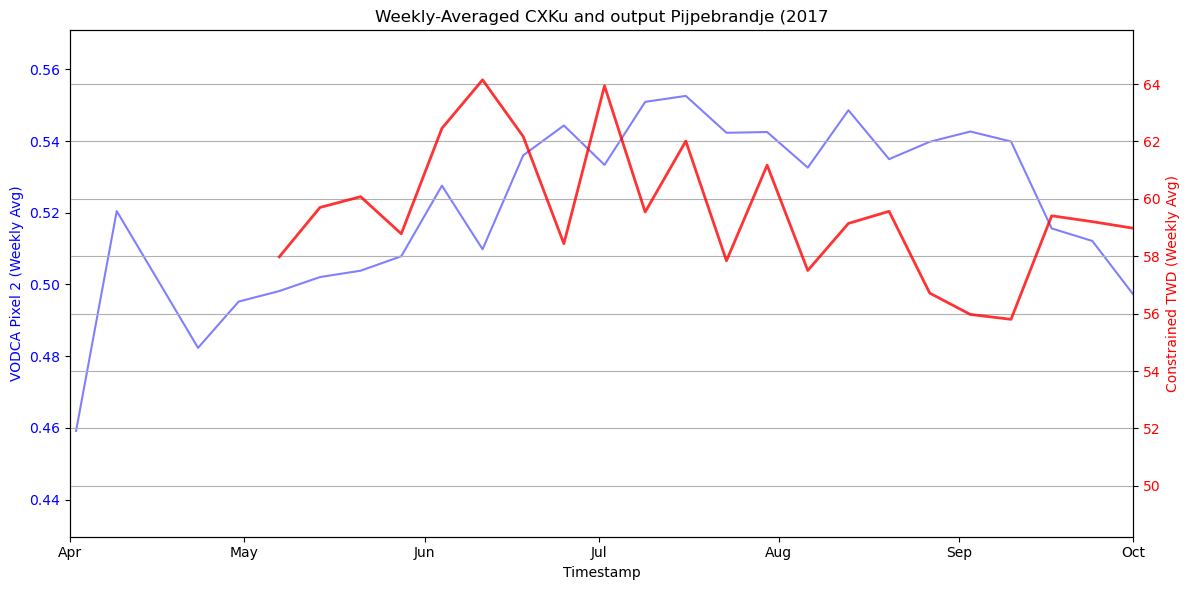

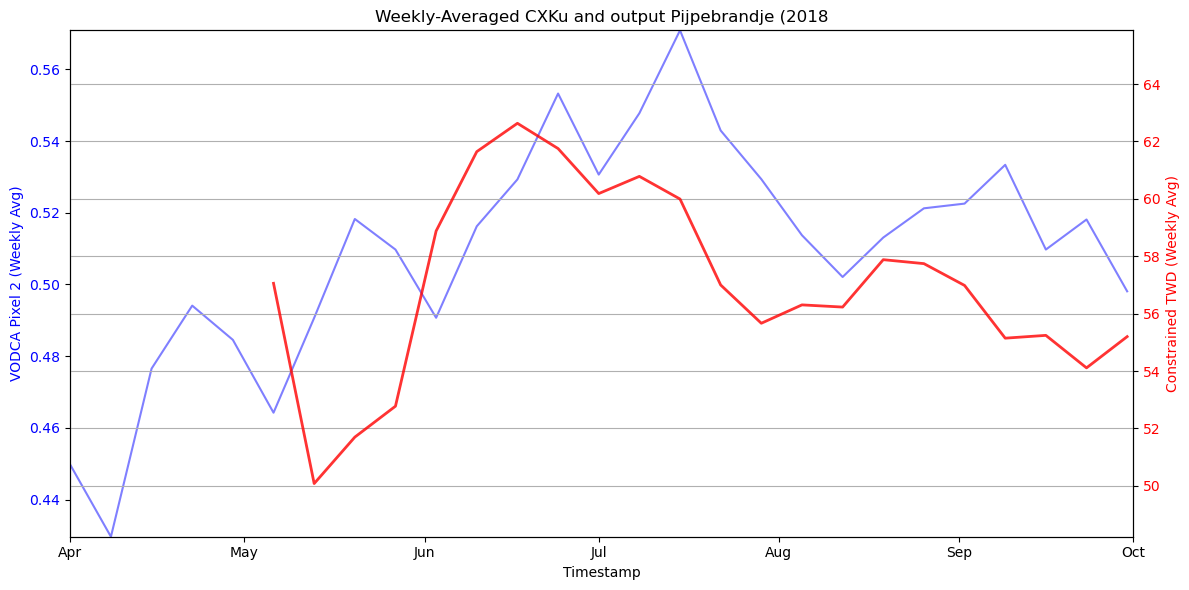

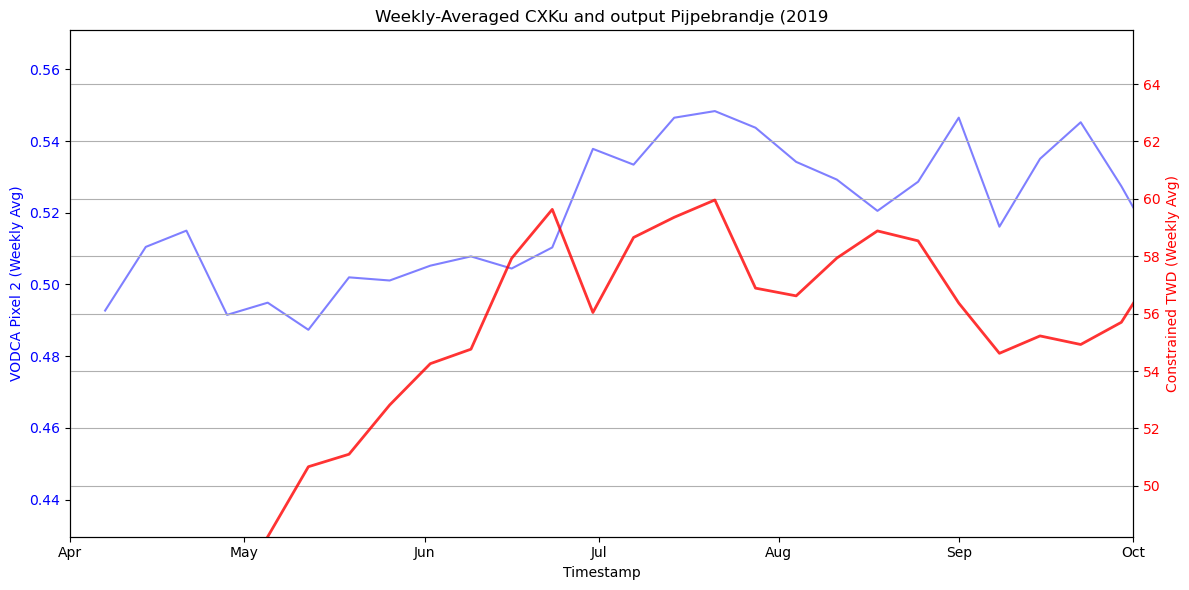

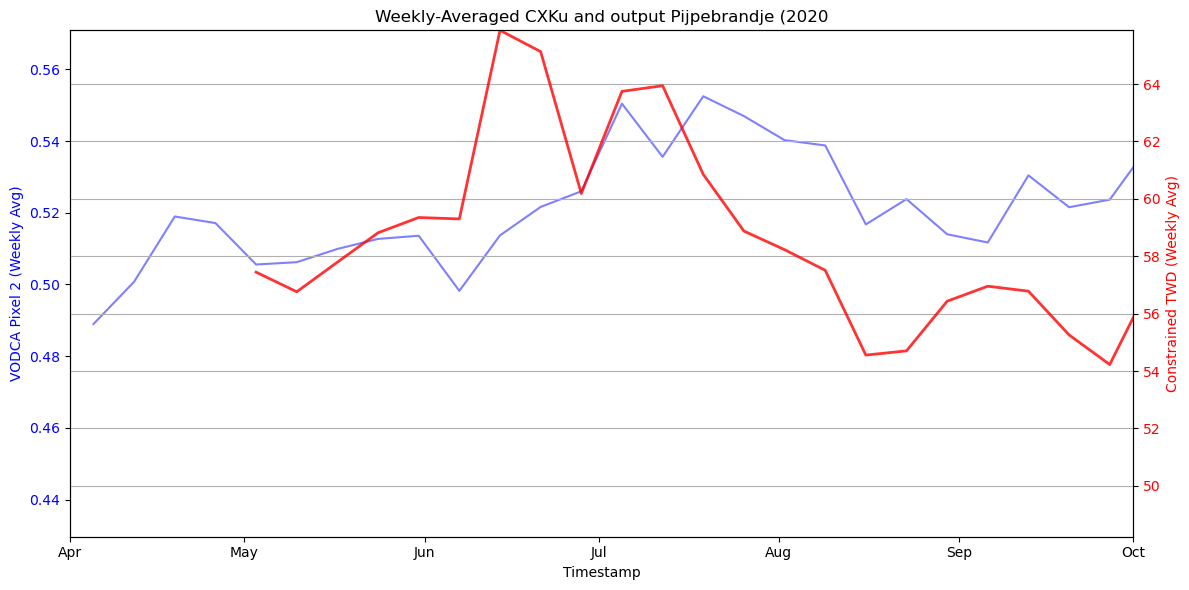

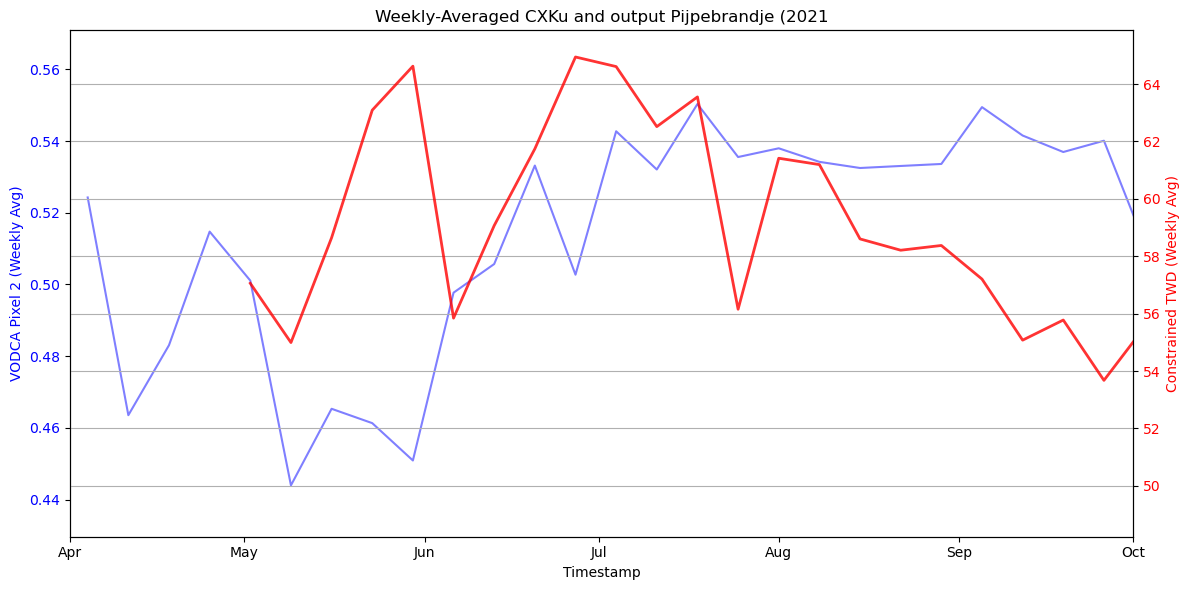

In [64]:
#Pijpebrandeje
years = range(2017, 2022) 

CXku_pixel_1_filtered["timestamp"] = pd.to_datetime(CXku_pixel_1_filtered["timestamp"])
constrained_pijpebrandje_daily["timestamp"] = pd.to_datetime(constrained_pijpebrandje_daily["timestamp"])

vodca_weekly = CXku_pixel_1_filtered.set_index("timestamp").resample("W").mean().reset_index()

constrained_pijpebrandje_weekly = constrained_pijpebrandje_daily.set_index("timestamp").resample("W").mean().reset_index()
vodca_min, vodca_max = vodca_weekly["vodca_value"].min(), vodca_weekly["vodca_value"].max()
constrained_min, constrained_max = constrained_pijpebrandje_weekly["Constrained_Max_Average"].min(), constrained_pijpebrandje_weekly["Constrained_Max_Average"].max()

for year in years:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    vodca_filtered_year = vodca_weekly[vodca_weekly["timestamp"].dt.year == year]
    constrained_leesten_filtered_year = constrained_pijpebrandje_weekly[constrained_pijpebrandje_weekly["timestamp"].dt.year == year]
    ax1.plot(vodca_filtered_year["timestamp"], vodca_filtered_year["vodca_value"], 
             linestyle='-', color="blue", alpha=0.5, linewidth=1.5, label="VODCA Pixel 2 (Weekly Avg)")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("VODCA Pixel 2 (Weekly Avg)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_ylim(vodca_min, vodca_max)
    ax2 = ax1.twinx()
    ax2.plot(constrained_leesten_filtered_year["timestamp"], constrained_leesten_filtered_year["Constrained_Max_Average"], 
             linestyle='-', color="red", alpha=0.8, linewidth=2, label="Constrained TWD (Weekly Avg)")
    ax2.set_ylabel("Constrained TWD (Weekly Avg)", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.set_ylim(constrained_min, constrained_max)
    plt.title(f"Weekly-Averaged CXKu and output Pijpebrandje ({year}")
    fig.tight_layout()
    plt.grid(True)
    ax1.xaxis.set_major_locator(mdates.MonthLocator())  
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax1.set_xlim(pd.Timestamp(f"{year}-04-01"), pd.Timestamp(f"{year}-10-01"))
    plt.show()


In [65]:
# Leesten
from scipy.stats import spearmanr

CXku_pixel_2_filtered = CXku_pixel_2_filtered.copy()  # avoid SettingWithCopyWarning
constrained_leesten_daily = constrained_leesten_daily.copy()

CXku_pixel_2_filtered["timestamp"] = pd.to_datetime(CXku_pixel_2_filtered["timestamp"])
constrained_leesten_daily["timestamp"] = pd.to_datetime(constrained_leesten_daily["timestamp"])


vodca_weekly = CXku_pixel_2_filtered.set_index("timestamp").resample("W").mean().reset_index()
constrained_leesten_weekly = constrained_leesten_daily.set_index("timestamp").resample("W").mean().reset_index()


all_vodca_values = []
all_constrained_values = []


for year in years:
    vodca_filtered_year = vodca_weekly[vodca_weekly["timestamp"].dt.year == year]
    constrained_leesten_filtered_year = constrained_leesten_weekly[constrained_leesten_weekly["timestamp"].dt.year == year]
    merged_data = pd.merge(vodca_filtered_year, constrained_leesten_filtered_year, on="timestamp", how="inner")
    merged_data = merged_data.dropna(subset=["vodca_value", "Constrained_Max_Average"])
    print(f"Year {year}: Data points available after merge = {len(merged_data)}")

    if len(merged_data) > 2 and merged_data["vodca_value"].nunique() > 1 and merged_data["Constrained_Max_Average"].nunique() > 1: #enough points for computing spearman
        
        correlation, p_value = spearmanr(merged_data["vodca_value"], merged_data["Constrained_Max_Average"])
        print(f"Year {year}: Spearman Correlation = {correlation:.3f}, p-value = {p_value:.3f}")
        all_vodca_values.extend(merged_data["vodca_value"].tolist())
        all_constrained_values.extend(merged_data["Constrained_Max_Average"].tolist())

    else:
        print(f"Year {year}: Not enough **unique** data for correlation calculation.")

if len(all_vodca_values) > 2 and len(set(all_vodca_values)) > 1 and len(set(all_constrained_values)) > 1:
    overall_corr, overall_p = spearmanr(all_vodca_values, all_constrained_values)
    print(f"\nOverall Spearman Correlation (2017-2021): {overall_corr:.3f}, p-value = {overall_p:.3f}")
else:
    print("\nNot enough unique data for overall correlation calculation.")


Year 2017: Data points available after merge = 22
Year 2017: Spearman Correlation = 0.150, p-value = 0.506
Year 2018: Data points available after merge = 22
Year 2018: Spearman Correlation = 0.518, p-value = 0.014
Year 2019: Data points available after merge = 23
Year 2019: Spearman Correlation = -0.136, p-value = 0.535
Year 2020: Data points available after merge = 23
Year 2020: Spearman Correlation = -0.191, p-value = 0.383
Year 2021: Data points available after merge = 23
Year 2021: Spearman Correlation = -0.305, p-value = 0.157

Overall Spearman Correlation (2017-2021): 0.094, p-value = 0.324


In [66]:
# Pijpe

CXku_pixel_1_filtered = CXku_pixel_1_filtered.copy()  # avoid SettingWithCopyWarning
constrained_pijpebrandje_daily = constrained_pijpebrandje_daily.copy()

CXku_pixel_1_filtered["timestamp"] = pd.to_datetime(CXku_pixel_1_filtered["timestamp"])
constrained_pijpebrandje_daily["timestamp"] = pd.to_datetime(constrained_pijpebrandje_daily["timestamp"])


vodca_weekly = CXku_pixel_1_filtered.set_index("timestamp").resample("W").mean().reset_index()
constrained_leesten_weekly = constrained_pijpebrandje_daily.set_index("timestamp").resample("W").mean().reset_index()


all_vodca_values = []
all_constrained_values = []


for year in years:
    vodca_filtered_year = vodca_weekly[vodca_weekly["timestamp"].dt.year == year]
    constrained_leesten_filtered_year = constrained_leesten_weekly[constrained_leesten_weekly["timestamp"].dt.year == year]
    merged_data = pd.merge(vodca_filtered_year, constrained_leesten_filtered_year, on="timestamp", how="inner")
    merged_data = merged_data.dropna(subset=["vodca_value", "Constrained_Max_Average"])
    print(f"Year {year}: Data points available after merge = {len(merged_data)}")

    if len(merged_data) > 2 and merged_data["vodca_value"].nunique() > 1 and merged_data["Constrained_Max_Average"].nunique() > 1: #enough points for computing spearman
        
        correlation, p_value = spearmanr(merged_data["vodca_value"], merged_data["Constrained_Max_Average"])
        print(f"Year {year}: Spearman Correlation = {correlation:.3f}, p-value = {p_value:.3f}")
        all_vodca_values.extend(merged_data["vodca_value"].tolist())
        all_constrained_values.extend(merged_data["Constrained_Max_Average"].tolist())

    else:
        print(f"Year {year}: Not enough **unique** data for correlation calculation.")

if len(all_vodca_values) > 2 and len(set(all_vodca_values)) > 1 and len(set(all_constrained_values)) > 1:
    overall_corr, overall_p = spearmanr(all_vodca_values, all_constrained_values)
    print(f"\nOverall Spearman Correlation (2017-2021): {overall_corr:.3f}, p-value = {overall_p:.3f}")
else:
    print("\nNot enough unique data for overall correlation calculation.")


Year 2017: Data points available after merge = 22
Year 2017: Spearman Correlation = -0.118, p-value = 0.601
Year 2018: Data points available after merge = 22
Year 2018: Spearman Correlation = 0.430, p-value = 0.046
Year 2019: Data points available after merge = 23
Year 2019: Spearman Correlation = 0.549, p-value = 0.007
Year 2020: Data points available after merge = 23
Year 2020: Spearman Correlation = 0.203, p-value = 0.354
Year 2021: Data points available after merge = 23
Year 2021: Spearman Correlation = -0.074, p-value = 0.737

Overall Spearman Correlation (2017-2021): 0.221, p-value = 0.018
